In [1]:
!pip install statsmodels
!pip install sklearn
!pip install datetime
!pip install seaborn

Processing c:\users\david\appdata\local\pip\cache\wheels\46\ef\c3\157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e\sklearn-0.0-py2.py3-none-any.whl


In [16]:
!pip install --upgrade mplfinance

  Using cached mpf_mc-0.54.0-cp37-none-win_amd64.whl (13.2 MB)
  Using cached kivy_deps.gstreamer_dev-0.1.18-cp37-cp37m-win_amd64.whl (3.8 MB)
  Using cached kivy_deps.glew_dev-0.1.12-cp37-cp37m-win_amd64.whl (319 kB)
  Using cached ffpyplayer-4.3.1-cp37-cp37m-win_amd64.whl (27.2 MB)
  Using cached pypiwin32-223-py3-none-any.whl (1.7 kB)
  Using cached ruamel.yaml-0.15.100-cp37-cp37m-win_amd64.whl (225 kB)
  Using cached kivy_deps.gstreamer-0.1.18-cp37-cp37m-win_amd64.whl (77.2 MB)
  Using cached mpf-0.54.1.tar.gz (1.0 MB)
  Using cached kivy_deps.sdl2_dev-0.1.23-cp37-cp37m-win_amd64.whl (660 kB)
  Using cached Kivy-1.11.1-cp37-cp37m-win_amd64.whl (4.1 MB)
  Using cached Pygments-2.3.1-py2.py3-none-any.whl (849 kB)
  Using cached pyserial-3.4-py2.py3-none-any.whl (193 kB)
  Using cached pyserial_asyncio-0.4-py3-none-any.whl (7.1 kB)
  Using cached sortedcontainers-2.1.0-py2.py3-none-any.whl (28 kB)
  Using cached asciimatics-1.11.0-py2.py3-none-any.whl (96 kB)
Processing c:\users\david

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

spyder 4.1.4 requires pyqt5<5.13; python_version >= "3", which is not installed.
spyder 4.1.4 requires pyqtwebengine<5.13; python_version >= "3", which is not installed.


In [60]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.stats.contingency_tables as sm_table
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve
from sklearn import tree
from sklearn import metrics
from datetime import datetime
import mplfinance as mpf
import data_utils #this data_utils file can be found in my github folder with this file

# Information needed to understand this project

This project developes a trading strategy based on candlestick data analysis. What is a candlestick? A candlestick is similar to a box and whisker plot and represents the price movement of the stock during a particular time frame. The top of a candlestick is the highest price for that stock during the time period, while the bottom is the lowest price. The top and bottom of the body of the candlestick represents the price at the very start and end of the time period. If the price started lower than it ended, then the candle will be 'Bullish' and colored white. If the price started higher than it ended, then the candle will be 'Bearish' and colored black. A pictoral example of a candlestick is shown below.

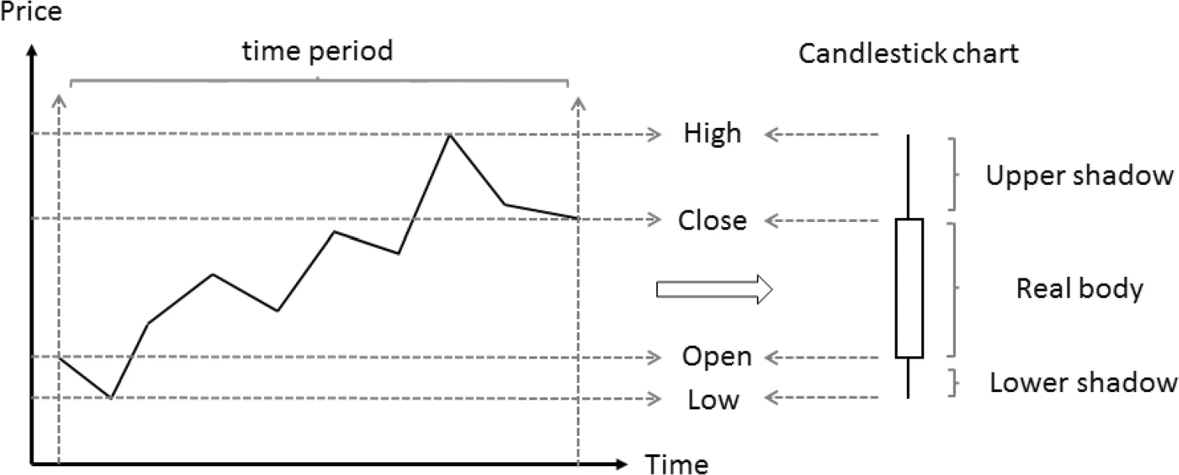

<b>Figure 1: </b> This figure visualizes the transformation of price activity into a candlestick. This figure came from [here](https://jfin-swufe.springeropen.com/articles/10.1186/s40854-020-00187-0/figures/1).

## Data Source <br>
I got my data through the yfinance API which was developed by Ran Aroussi to get data through Yahoo! Finance. Information regarding this API is found [here](https://aroussi.com/post/python-yahoo-finance). You are able to pull candlestick data from varying time frames using this API.<br>
My project uses 1 minute time period candlestick data. One thing about such a short time frame is that Yahoo! Finance only makes this data available for the past 7 days. Therefore, I have written separate code that interacts with this API to collect stock data once a week and append it to csv file per stock symbol of interest.<br>
For this project I have chosen to study Apple (AAPL), Facebook (FB), Advanced Micro Devices (AMD), Netflix (NFLX), Microsoft (MSFT), and Nvidia (NVDA). The csv files have been posted [here](https://github.com/harperd17/Candlestick-Trading-Strategy/tree/main/Data) for the sake of this project. There is no need to download them, though, because this notebook pulls directly from my Github.

## Project Goal <br>
The goal of this project is to find occurences of a candlestick pattern, known as a generalized [hanging man](https://www.investopedia.com/articles/active-trading/040914/understanding-hanging-man-optimistic-candlestick-pattern.asp) (a traditional hanging man is seen as a trend reversal signal and traded as such. However, this project generalizes this pattern to both trend continuation and trend reversal) and developes a trading strategy around it and performs analysis in order to find out which conditions this strategy works best under.<br>
My basic strategy is as follows:<br>
- Find occurence of a candlestcik with a tall shadow (wick) in one direction, and a small wick in the opposite direction.<br>
- Immediately enter at the closing of the candlestick and set up exit rules.<br>
    - Set a target exit at the end of the tall shadow of the hanging man candlestick - if target is reached, we have a winning trade.<br>
    - Set a stop loss in the opposite direction of the target in case the trade goes against you - if the stop loss is reached, we have a losing trade.<br>

An example of this trading strategy is shown in Figure 2 below:

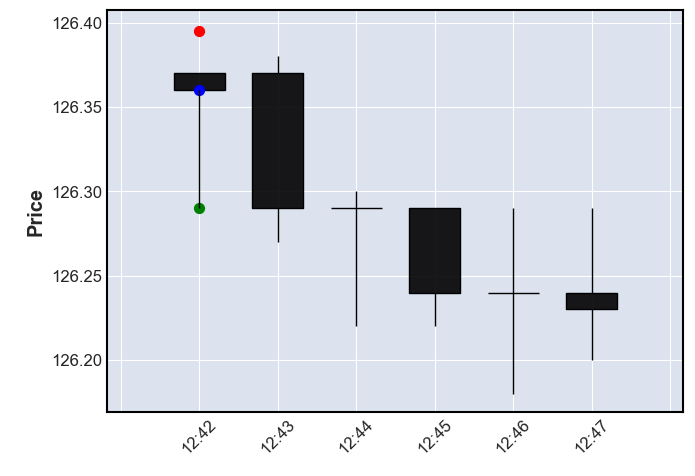

<b>Figure 2: </b>This shows a winning example of the trading strategy acting on a 'Bearish' candlestick. The blue dot represents the entry of the trade. Once entered, the stop loss and target price are set. The red dot represents the stop loss price, and the green dot represents the target price.

# Preparing the Data

In [2]:
data_file_path = 'https://raw.githubusercontent.com/harperd17/Candlestick-Trading-Strategy/main/Data'

In [3]:
tickers = ['AAPL','FB','AMD','NFLX','MSFT','NVDA']
time_frames = ['1m']
minutes = [1]

## As I pull each file, I'm appending it to a main data frame

In [4]:
for symbol in tickers:
    for time in time_frames:
        file_location = data_file_path+'/'+symbol+time+"Data.csv"
        new_data = pd.read_csv(file_location)
        new_data['Date'] = pd.to_datetime(new_data['Date'],format='%Y-%m-%d %H:%M:%S')
        new_data['Ticker'] = [symbol]*new_data.shape[0]
    if symbol == tickers[0]:
        grand_frame = new_data
    else:
        grand_frame = grand_frame.append(new_data)

In [5]:
#creating rules for what is considered normal trading hours (9:30AM - 4PM). There is after hours trading as well, but there
#is lower liquidity in these hours
#Also, the data isn't reliable during after hours
normal_hours_str = ['9:30','16:00']
normal_hours = [datetime.strptime(normal_hours_str[0],'%H:%M'),datetime.strptime(normal_hours_str[1],'%H:%M')]

In [6]:
#taking out all after hours data
#due to the indexing, it's easier to send subsets by ticker into the function
for ticker in tickers:
    tick_frame = grand_frame[grand_frame['Ticker']==ticker]
    #call the onlyNormalHours function to take out the after hours candlesticks
    tick_frame = data_utils.onlyNormalHours(tick_frame.copy(),normal_hours)
    if ticker == tickers[0]:
        new_frame = tick_frame
    else:
        new_frame = new_frame.append(tick_frame)

In [7]:
grand_frame = new_frame.copy()
#setting the index of the dataframe to the dates - this is required for later use
grand_frame.index = grand_frame['Date']
#many of the functions I've written use the column name spelled as 'dates'
grand_frame['dates'] = grand_frame['Date']
del grand_frame['Date']

## Inspect the chart for data quality before proceeding

Apple Candlestick Chart


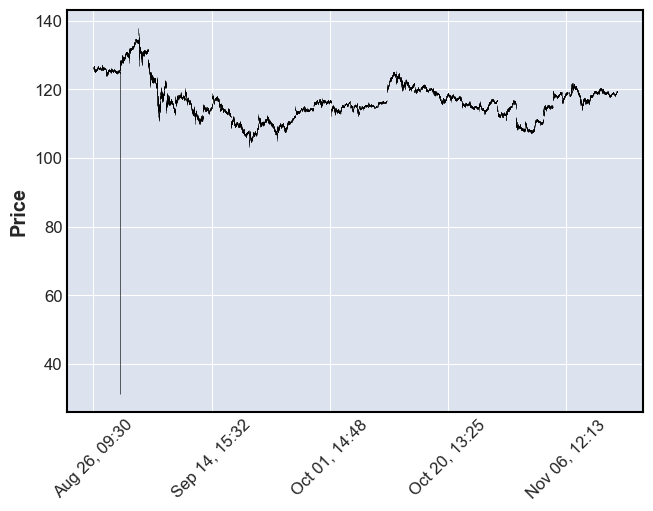

In [8]:
print('Apple Candlestick Chart')
data_utils.plotResults(grand_frame[grand_frame['Ticker']=='AAPL'], [], [], [], [], [],False,[])

Unfortunately, it looks like the data isn't 100% accurate. The super long shadow on one of the candlesticks is not correct. I've made the decision to set the low equal to the open of that period.

In [9]:
temp = grand_frame.loc['2020-08-28 16:00:00','Low']
temp[0] = 124.74
grand_frame.loc['2020-08-28 16:00:00','Low'] = temp

C:\Users\david\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3417: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


Facebook Candlestick Chart


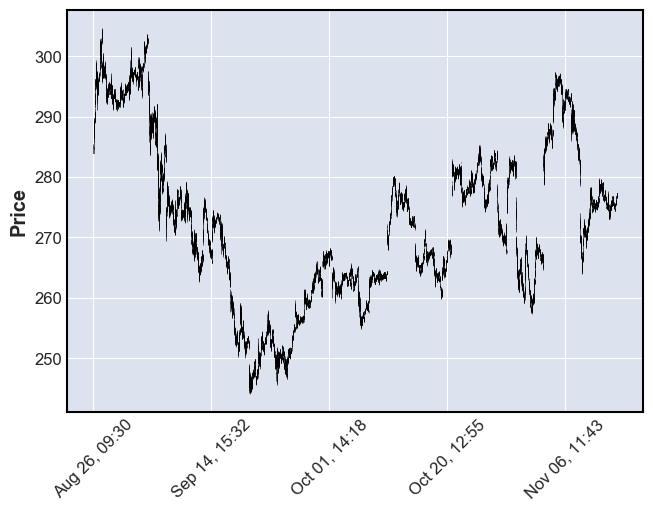

In [10]:
print('Facebook Candlestick Chart')
data_utils.plotResults(grand_frame[grand_frame['Ticker']=='FB'], [], [], [], [], [],False,[])

Advance Micro Devices Candlestick Chart


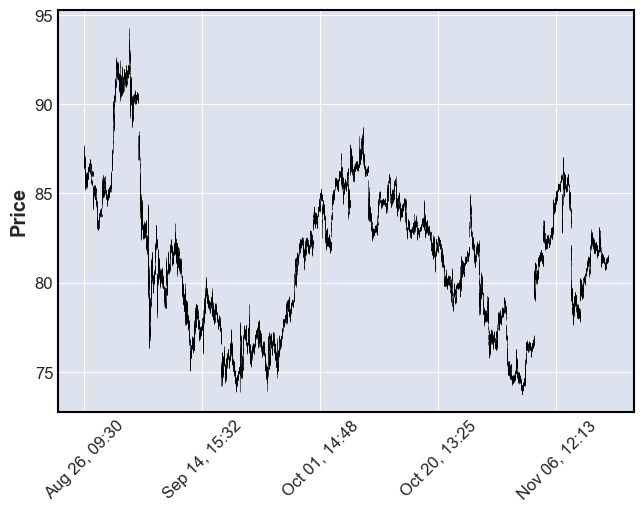

In [11]:
print('Advance Micro Devices Candlestick Chart')
data_utils.plotResults(grand_frame[grand_frame['Ticker']=='AMD'], [], [], [], [], [],False,[])

Netflix Candlestick Chart


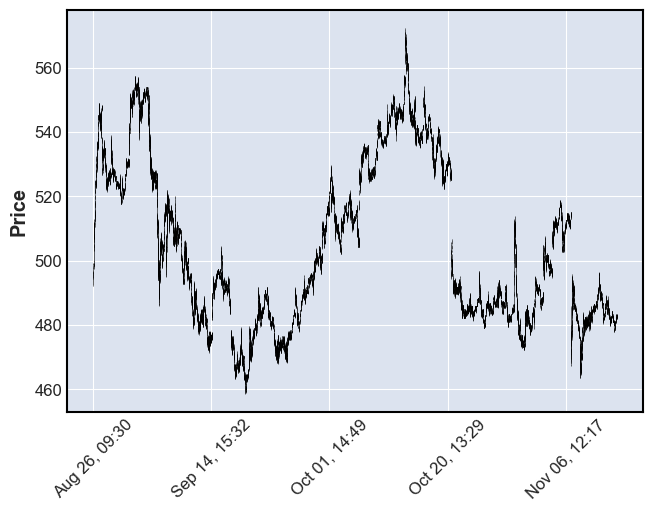

In [12]:
print('Netflix Candlestick Chart')
data_utils.plotResults(grand_frame[grand_frame['Ticker']=='NFLX'], [], [], [], [], [],False,[])

Microsoft Candlestick Chart


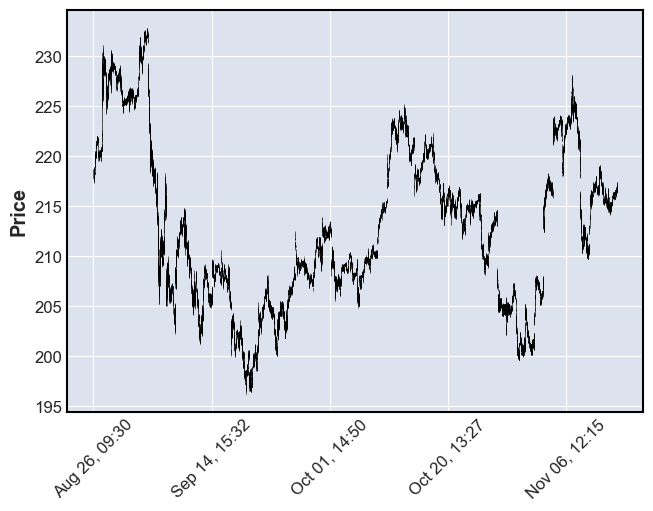

In [13]:
print('Microsoft Candlestick Chart')
data_utils.plotResults(grand_frame[grand_frame['Ticker']=='MSFT'], [], [], [], [], [],False,[])

Nvidia Candlestick Chart


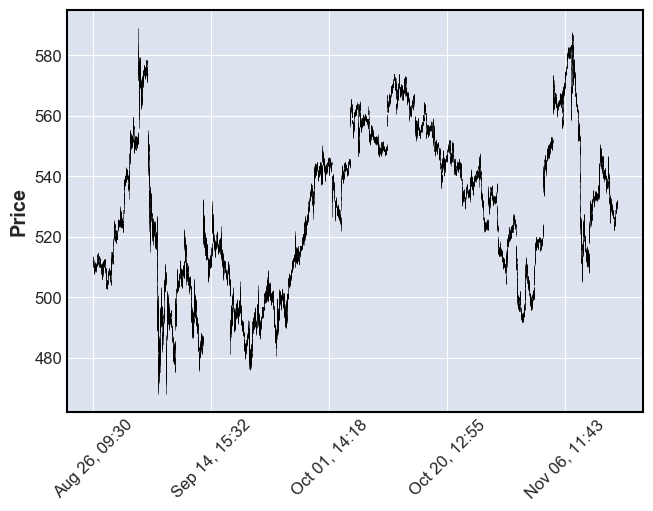

In [14]:
print('Nvidia Candlestick Chart')
data_utils.plotResults(grand_frame[grand_frame['Ticker']=='NVDA'], [], [], [], [], [],False,[])

The rest of the charts look good!

## Now that the data has been inspected and revised for accuracy, let's move on to finding the occurrences of the hanging man candlestick pattern

In [15]:
#finding the occurrences of a hanging man
#3.75 is the smallest ratio of tall shadow length to body length to be classified as a hanging man candle
#0 is the largest ratio of short shadow length to body length to be classified as a hanging man candle
h1 = 2 #3.75
h2 = 0.375
#for setting the targets and stop losses - target will be 1 * length of tall shadow - stop loss will be 1/s1 of the target
s1 = 1.75#3.5
s2 = 1
grand_frame['Hanging Man'] = data_utils.findHangingMans(grand_frame.copy(), h1, h2)

#specifying which moving average (SMAs) to grab. These average the closing prices from a specified look back period.
#for example, 9 - period SMA uses the 9 preceding closing prices to form an average for each candlestick
emas = [9,13,21,50,200]

#getting the moving averages
#SMA stands for simple moving average
for ema in emas:
    #this needs to be done 'per ticker'
    ema_values = []
    for ticker in tickers:
        tick_frame = grand_frame[grand_frame['Ticker']==ticker]
        ema_values += list(data_utils.getSMA(tick_frame['Close'],ema))
    grand_frame[str(ema)+'SMA'] = ema_values
    grand_frame['Distance from '+str(ema)+'SMA'] = 100*(grand_frame['Close'] - grand_frame[str(ema)+'SMA'])/grand_frame[str(ema)+'SMA']
    
#getting the moving average for the candle sizes (high-low, not open-close)
#also getting the moving averages for the volumes
#also getting the moving standard deviation of candle size as a measure of volatility
grand_frame['Size'] = grand_frame['High'] - grand_frame['Low']

for ema in emas:
    #this needs to be done 'per ticker'
    mov_values = []
    vol_values = []
    std_values = []
    for ticker in tickers:
        tick_frame = grand_frame[grand_frame['Ticker']==ticker]
        mov_values += list(data_utils.getSMA(tick_frame['Size'],ema))
        vol_values += list(data_utils.getSMA(tick_frame['Volume'],ema))
        std_values += list(tick_frame['Size'].rolling(window=ema).std())
    grand_frame[str(ema)+'Moving Size'] = mov_values
    grand_frame[str(ema)+'Moving Volume'] = vol_values
    grand_frame[str(ema)+'Moving Std'] = std_values
    grand_frame['Distance from '+str(ema)+'Moving Size'] = 10*(grand_frame['Size'] - grand_frame[str(ema)+'Moving Size'])/grand_frame[str(ema)+'Moving Size']
    grand_frame['Distance from '+str(ema)+'Moving Volume'] = 1000*(grand_frame['Volume'] - grand_frame[str(ema)+'Moving Volume'])/grand_frame[str(ema)+'Moving Volume']
    grand_frame['Distance from '+str(ema)+'Moving Std'] = 10*(grand_frame['Size'] - grand_frame[str(ema)+'Moving Std'])/grand_frame[str(ema)+'Moving Std']
    
#getting the successes - calls a function that goes through each hanging man, and determines if the target (success) or stop loss (failure) was reached
#again, this needs to be done by ticker
all_successes = []
all_directions = []
for ticker in tickers:
    tick_frame = grand_frame[grand_frame['Ticker']==ticker]
    success, direction = data_utils.hangingManSuccess(tick_frame.copy(), 'Hanging Man', s1, s2)
    all_successes += success
    all_directions += direction
grand_frame['Successes'] = all_successes
grand_frame['Directions'] = all_directions

#I want to also derive the feature 'body length' which is just the difference between the open and close of each candle
#but I will also divide by the open price so the values are sort of standardized into %
grand_frame['Body Length'] = (grand_frame['Close'] - grand_frame['Open'])/grand_frame['Open']

#the few lines below this are only used for visualizations - don't worry about understanding why I'm making them
grand_frame['Success Closes'] = grand_frame['Close']*grand_frame['Successes']
grand_frame['Success Closes'] = grand_frame['Success Closes'].replace(0,np.nan)
grand_frame['Failure Closes'] = grand_frame['Close']*np.absolute(grand_frame['Successes']-1)
grand_frame['Failure Closes'] = grand_frame['Failure Closes'].replace(0,np.nan)

### Since the moving average features require atleast how many periods its average over in order to make the first value, the first 'period' lines will be n/a, so let's remove them

In [16]:
#using the 200EMA column for this because all the other n/as will also be removed by removing the 200EMA n/a's
to_delete = list(grand_frame.index[grand_frame['200SMA'].isnull()])

In [17]:
#now drop the rows
grand_frame = grand_frame.drop(to_delete)

In [18]:
#now to get the data that only has hanging man occurrence candlesticks!
subset_df = grand_frame[grand_frame['Hanging Man']==1]

In [19]:
subset_df.shape

(6793, 54)

In [20]:
#below is a snapshot of the first 5 lines of data
subset_df.head().T

Date                            2020-08-26 12:58:00  2020-08-26 13:14:00  \
High                                         126.31               126.07   
Low                                          126.25               126.01   
Open                                         126.29               126.07   
Close                                        126.29               126.06   
Volume                                        32995                42061   
Ticker                                         AAPL                 AAPL   
dates                           2020-08-26 12:58:00  2020-08-26 13:14:00   
Hanging Man                                       1                    1   
9SMA                                        126.369              126.047   
Distance from 9SMA                       -0.0624275            0.0105781   
13SMA                                       126.327              126.085   
Distance from 13SMA                      -0.0292282           -0.0195229   
21SMA                                       126.323              126.159   
Distance from 21SMA                      -0.0263873           -0.0785101   
50SMA                                       126.404              126.328   
Distance from 50SMA                      -0.0900289            -0.212304   
200SMA                                       125.95              125.919   
Distance from 200SMA                        0.26959             0.112096   
Size                                           0.06                 0.06   
9Moving Size                              0.0988889             0.122222   
9Moving Volume                              69537.7              70581.4   
9Moving Std                               0.0301846            0.0489331   
Distance from 9Moving Size                 -3.93258             -5.09091   
Distance from 9Moving Volume               -525.509             -404.079   
Distance from 9Moving Std                   9.87767              2.26165   
13Moving Size                              0.104615             0.111538   
13Moving Volume                             71125.4              63077.9   
13Moving Std                               0.028465            0.0441298   
Distance from 13Moving Size                -4.26471             -4.62069   
Distance from 13Moving Volume              -536.101              -333.19   
Distance from 13Moving Std                  11.0785              3.59627   
21Moving Size                             0.0990476             0.107619   
21Moving Volume                             79929.5              62464.4   
21Moving Std                              0.0296487            0.0376702   
Distance from 21Moving Size                -3.94231             -4.42478   
Distance from 21Moving Volume              -587.199             -326.641   
Distance from 21Moving Std                  10.2369              5.92769   
50Moving Size                                0.1108               0.1078   
50Moving Volume                              100656              85856.9   
50Moving Std                              0.0390102             0.037866   
Distance from 50Moving Size                -4.58484             -4.43414   
Distance from 50Moving Volume              -672.201             -510.103   
Distance from 50Moving Std                  5.38059              5.84533   
200Moving Size                              0.13505               0.1235   
200Moving Volume                             106855              96763.1   
200Moving Std                              0.069687            0.0576138   
Distance from 200Moving Size                -5.5572              -5.1417   
Distance from 200Moving Volume             -691.217              -565.32   
Distance from 200Moving Std                -1.39007             0.414177   
Successes                                         1                    0   
Directions                                       -1                   -1   
Body Length                                     

# Exploratory Data Analysis

In [21]:
#first, I'd like to get the overall success rate of the this pattern
initial_success = sum(subset_df['Successes'])/subset_df.shape[0]
print(initial_success)

0.36302075666126893


In [22]:
#now let's take a look at the success rates by Stock Symbol
tick_success = []
for ticker in tickers:
    tick_frame = subset_df[subset_df['Ticker']==ticker]
    success = sum(tick_frame['Successes'])/tick_frame.shape[0]
    tick_success.append(success)

Text(0, 0.5, 'Success Rate %')

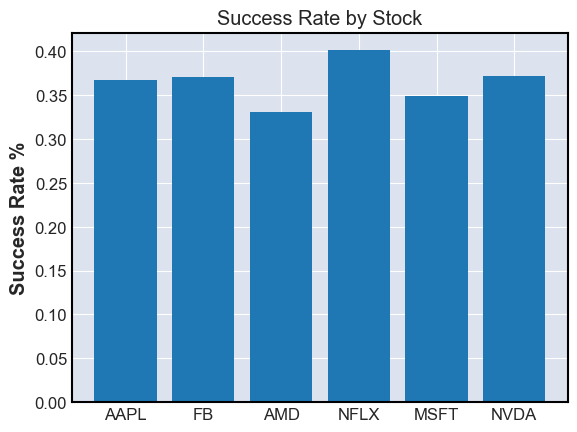

In [23]:
plt.bar(range(len(tickers)),tick_success)
plt.xticks(ticks = range(len(tickers)),labels = tickers)
plt.title('Success Rate by Stock')
plt.ylabel('Success Rate %')

The success rates look uniform across the six different stocks. Therefore, for the rest of this notebook, I will do analysis on the combined data as a whole.

## Next let's look at how the success rates vary by direction of candle

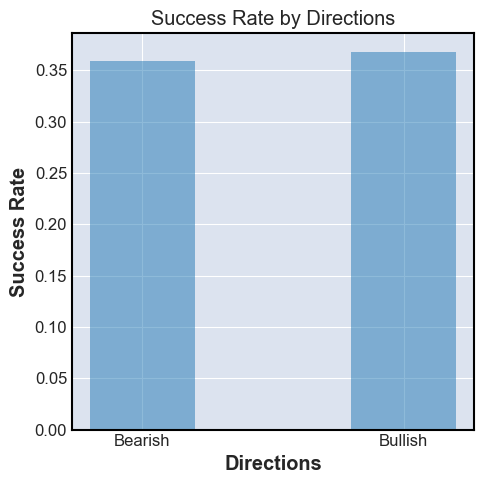

In [88]:
fig, ax = plt.subplots()
fig.set_size_inches(5, 5)
ax = data_utils.getRates(subset_df,'Directions','Successes',ax)
ax[0].set_xticklabels(['Bearish','Bullish'])

fig.tight_layout()

This is good because it shows this strategy is pretty consistent whether you're betting on the market going up or down

## Hypothesis 1:
There exists trade conditions related to the price proximity to various moving averages that yield statistically significantly higher success rates.

When plotting, I am removing the bottom and top 1% of the data because it really hides the patterns in the middle 98% of the data.

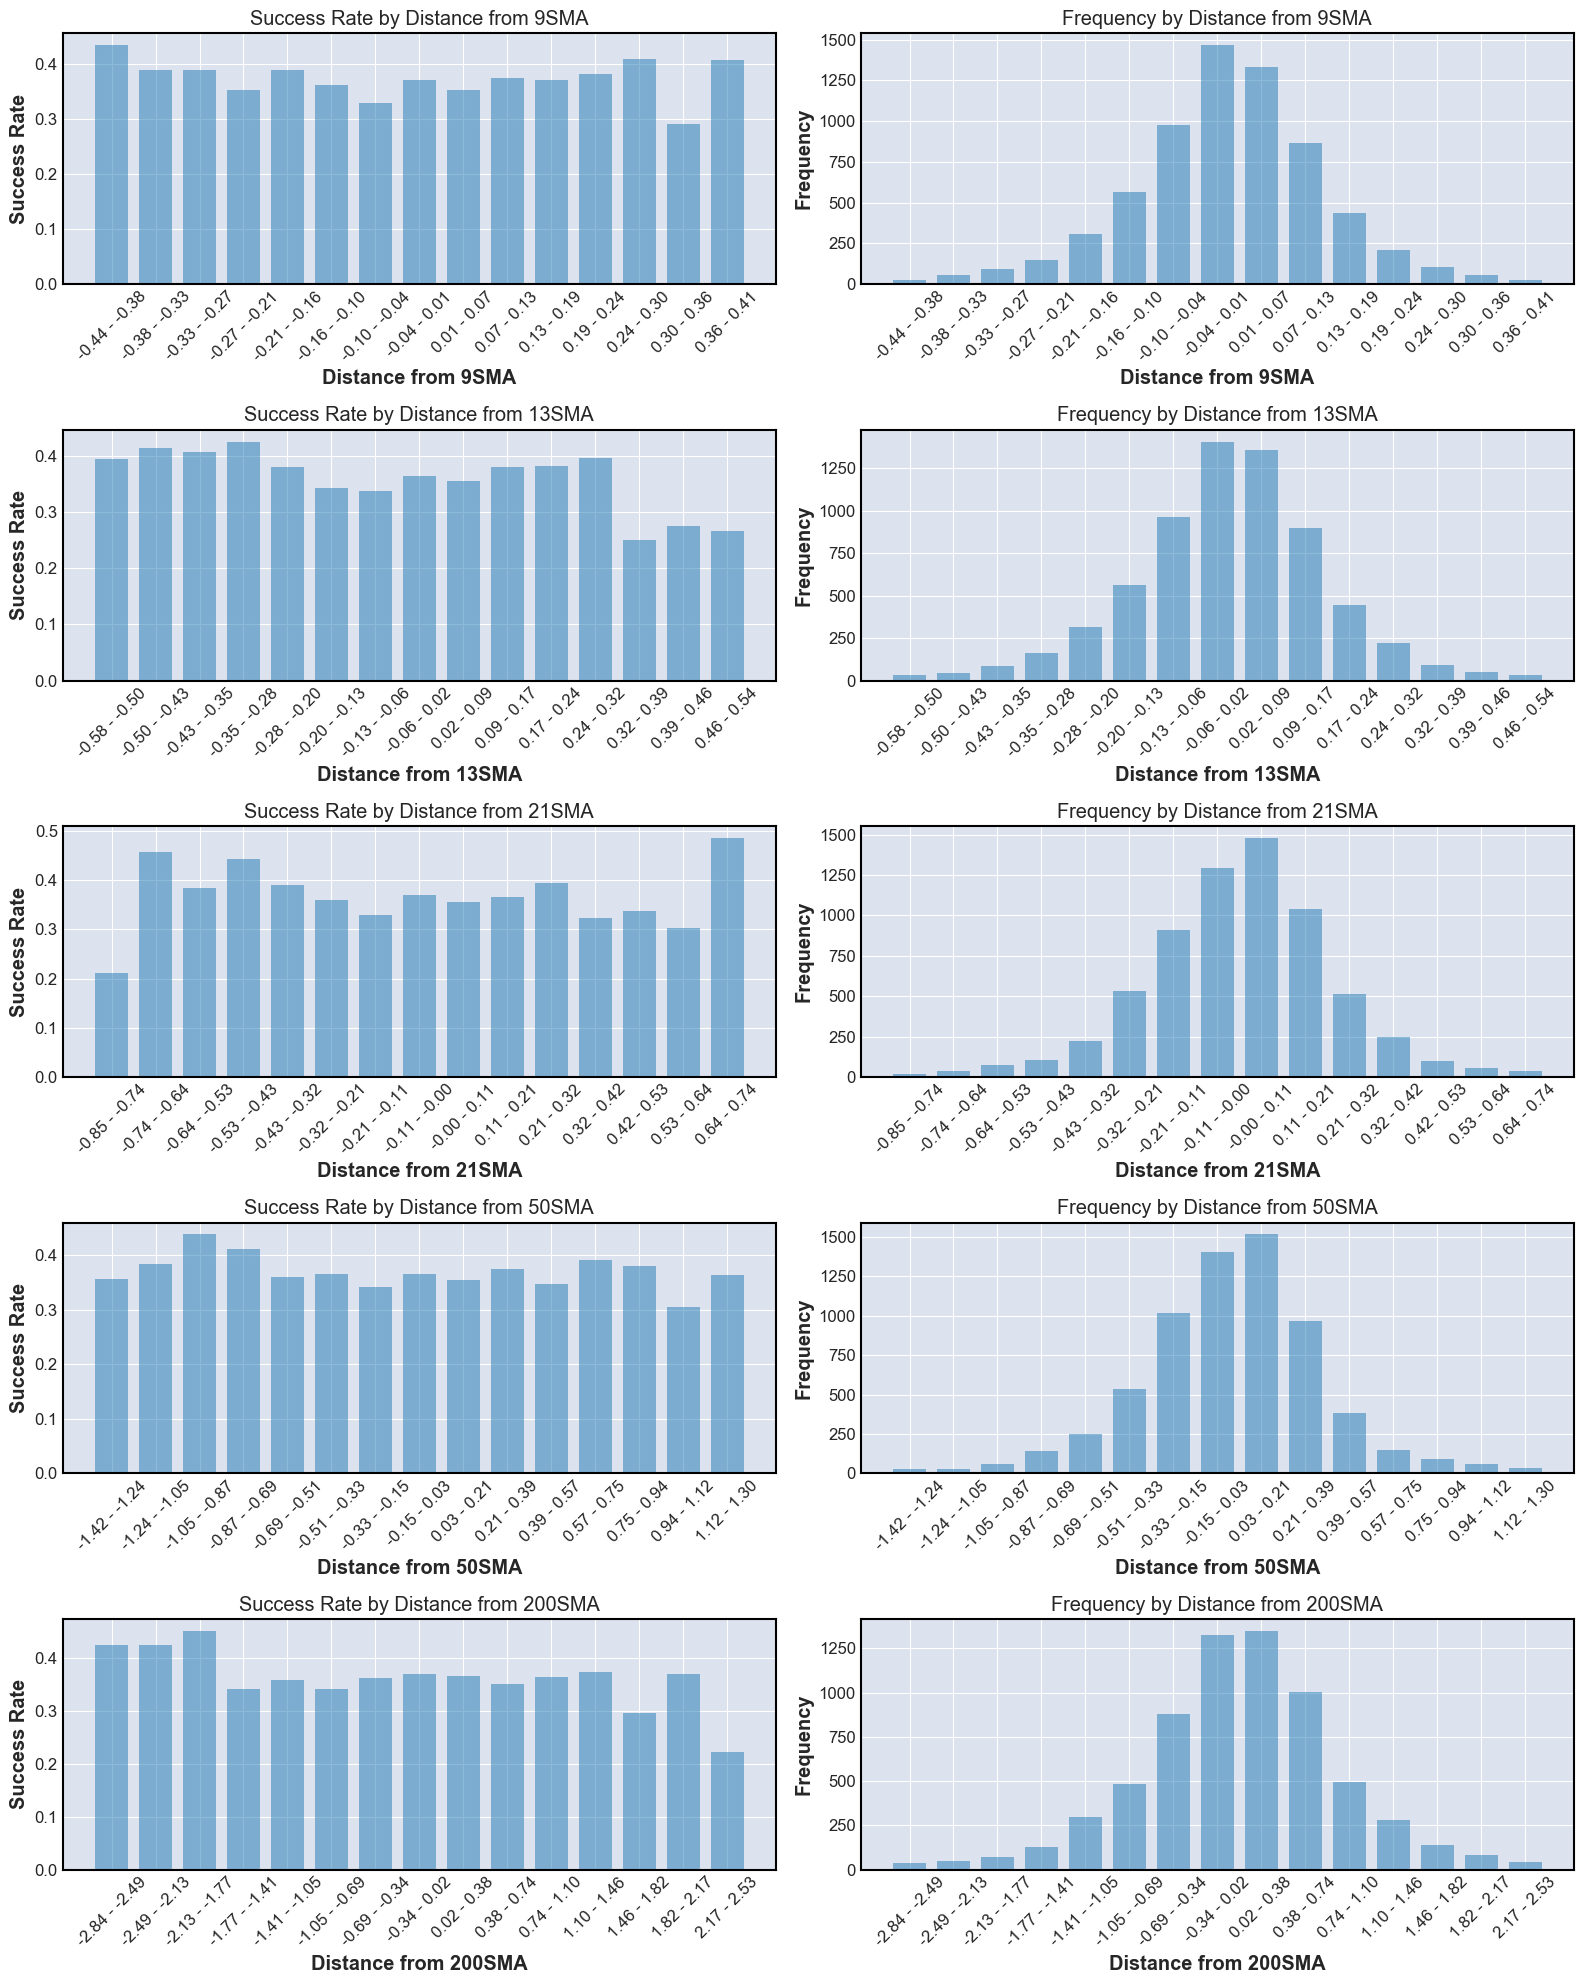

In [24]:
p_variable1 = 'Distance from 9SMA'
p_variable2 = 'Distance from 13SMA'
p_variable3 = 'Distance from 21SMA'
p_variable4 = 'Distance from 50SMA'
p_variable5 = 'Distance from 200SMA'
#bins is the number of bars to group the data in for the plots below
# plots on the left show the success rates for different values of the moving averages
# plots on the right show the distribution of the values of the moving averages. This is useful because if there is
#a high success rate in the one of the bins on the left plot, then we can check how many values made up that bin, and
#we can get a better idea of how significant it really is
bins = 15
fig,ax = plt.subplots(5,2)
fig.set_size_inches(16, 20)
ax[0,0], bins00 = data_utils.plotBins(data_utils.removeOutliers(0.01,0.99,subset_df,p_variable1),p_variable1,'Successes',ax[0,0],bins)
ax[0,1] = data_utils.plotHist(data_utils.removeOutliers(0.01,0.99,subset_df,p_variable1),p_variable1,ax[0,1],bins00)
ax[1,0], bins10 = data_utils.plotBins(data_utils.removeOutliers(0.01,0.99,subset_df,p_variable2),p_variable2,'Successes',ax[1,0],bins)
ax[1,1] = data_utils.plotHist(data_utils.removeOutliers(0.01,0.99,subset_df,p_variable2),p_variable2,ax[1,1],bins10)
ax[2,0], bins20 = data_utils.plotBins(data_utils.removeOutliers(0.01,0.99,subset_df,p_variable3),p_variable3,'Successes',ax[2,0],bins)
ax[2,1] = data_utils.plotHist(data_utils.removeOutliers(0.01,0.99,subset_df,p_variable3),p_variable3,ax[2,1],bins20)
ax[3,0], bins30 = data_utils.plotBins(data_utils.removeOutliers(0.01,0.99,subset_df,p_variable4),p_variable4,'Successes',ax[3,0],bins)
ax[3,1] = data_utils.plotHist(data_utils.removeOutliers(0.01,0.99,subset_df,p_variable4),p_variable4,ax[3,1],bins30)
ax[4,0], bins40 = data_utils.plotBins(data_utils.removeOutliers(0.01,0.99,subset_df,p_variable5),p_variable5,'Successes',ax[4,0],bins)
ax[4,1] = data_utils.plotHist(data_utils.removeOutliers(0.01,0.99,subset_df,p_variable5),p_variable5,ax[4,1],bins40)
fig.tight_layout()

<b>Notes: </b>Overall, these plots show relatively uniform distributions of the success rates as a function of the candlesticks distance scaled distance from various moving averages. There are bars in places that show higher success rates, but when comparing the bins to the frequencies in the histograms to the right, they are occurring in low frequency areas, which means we can't really rely on those higher success rates.

#### Testing out Bullish Instances of Hanging Man Only

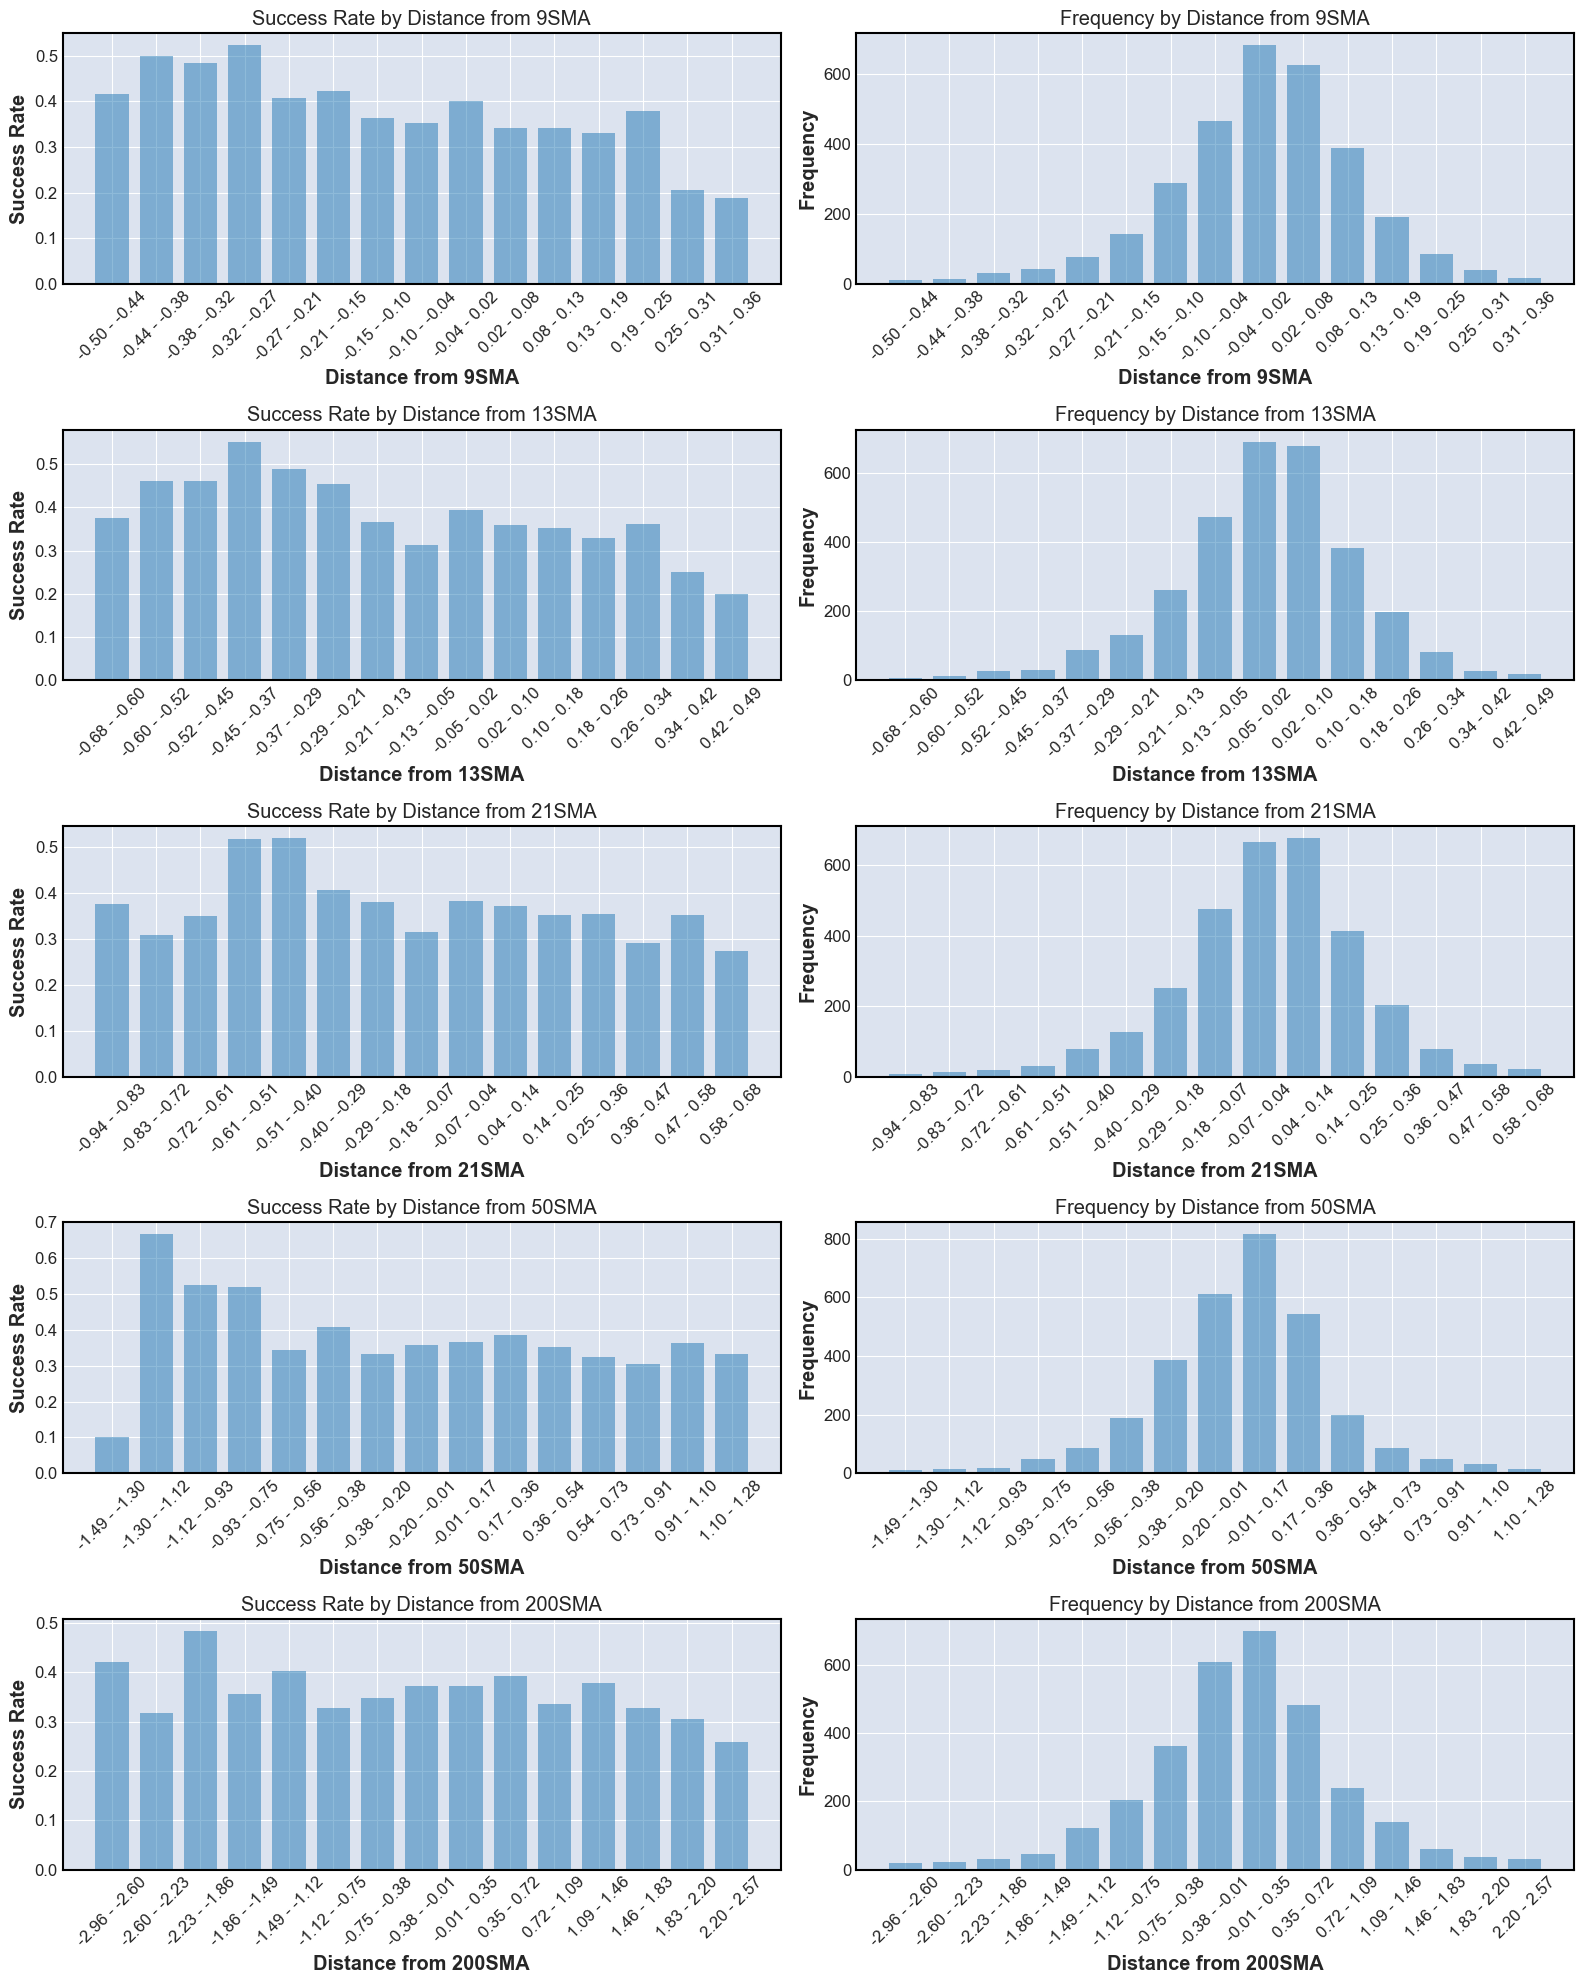

In [25]:
p_variable1 = 'Distance from 9SMA'
p_variable2 = 'Distance from 13SMA'
p_variable3 = 'Distance from 21SMA'
p_variable4 = 'Distance from 50SMA'
p_variable5 = 'Distance from 200SMA'
bins = 15
fig,ax = plt.subplots(5,2)
fig.set_size_inches(16, 20)
ax[0,0], bins00 = data_utils.plotBins(data_utils.removeOutliers(0.01,0.99,subset_df[subset_df['Directions']==1],p_variable1),p_variable1,'Successes',ax[0,0],bins)
ax[0,1] = data_utils.plotHist(data_utils.removeOutliers(0.01,0.99,subset_df[subset_df['Directions']==1],p_variable1),p_variable1,ax[0,1],bins00)
ax[1,0], bins10 = data_utils.plotBins(data_utils.removeOutliers(0.01,0.99,subset_df[subset_df['Directions']==1],p_variable2),p_variable2,'Successes',ax[1,0],bins)
ax[1,1] = data_utils.plotHist(data_utils.removeOutliers(0.01,0.99,subset_df[subset_df['Directions']==1],p_variable2),p_variable2,ax[1,1],bins10)
ax[2,0], bins20 = data_utils.plotBins(data_utils.removeOutliers(0.01,0.99,subset_df[subset_df['Directions']==1],p_variable3),p_variable3,'Successes',ax[2,0],bins)
ax[2,1] = data_utils.plotHist(data_utils.removeOutliers(0.01,0.99,subset_df[subset_df['Directions']==1],p_variable3),p_variable3,ax[2,1],bins20)
ax[3,0], bins30 = data_utils.plotBins(data_utils.removeOutliers(0.01,0.99,subset_df[subset_df['Directions']==1],p_variable4),p_variable4,'Successes',ax[3,0],bins)
ax[3,1] = data_utils.plotHist(data_utils.removeOutliers(0.01,0.99,subset_df[subset_df['Directions']==1],p_variable4),p_variable4,ax[3,1],bins30)
ax[4,0], bins40 = data_utils.plotBins(data_utils.removeOutliers(0.01,0.99,subset_df[subset_df['Directions']==1],p_variable5),p_variable5,'Successes',ax[4,0],bins)
ax[4,1] = data_utils.plotHist(data_utils.removeOutliers(0.01,0.99,subset_df[subset_df['Directions']==1],p_variable5),p_variable5,ax[4,1],bins40)
fig.tight_layout()

<b>Notes: </b>These plots above are showing the same information as in the previous figure, except the data is subset on only containing candlesticks where the associated trade is bullish. My intuition for this is that hanging man candlesticks are often seen as a trend reversal. Therefore, it makes sense that in some of the plots (like in the 9-period, 13-period, and 50-period plots), the success rates seem to be trending down from left to right. As the sayig goes, what goes down must come up, the farther below the moving averages the price falls, the more likely it may be that a trend reversal happens.<br>
I'm going to create three binary variables:<br>
- <b>Bullish9SMA</b> - takes a value of 1 if the Distance from 9SMA is less than or equal to -0.1. Otherwise is 0.
- <b>Bullish 13SMA</b> - takes a value of 1 if the Distance from 13SMA is less than or equal to -0.21. Otherwise is 0.
- <b>Bullish 50SMA</b> - takes a value of 1 if the Distance from 50SMA is less than or equal to -0.39. Otherwise is 0.
Then, I will perform odds ratios tests to see if the success rates within each of these variables are significantly different. If any of them yield statistically significantly higher success rates, the variable with the highest difference will be kept and added to the data set.

In [26]:
bullish9SMA = subset_df[p_variable1][subset_df['Directions']==1] <= -0.1
bullish9SMA = bullish9SMA.astype(int)
bullish13SMA = subset_df[p_variable2][subset_df['Directions']==1] <= -0.21
bullish13SMA = bullish13SMA.astype(int)
bullish50SMA = subset_df[p_variable4][subset_df['Directions']==1] <= -0.39
bullish50SMA = bullish50SMA.astype(int)

In [27]:
#now I need to create a table for the odds ratios computations
successes = subset_df['Successes'][subset_df['Directions']==1]
var_set = [bullish9SMA,bullish13SMA,bullish50SMA]
table_rows = []
for v in var_set:
    l0 = len(v[v==0])
    s0 = sum(successes[list(v==0)])/l0
    l1 = len(v[v==1])
    s1 = sum(successes[list(v==1)])/l1
    table_rows.append([0,1,s0,s1,l0,l1])
table = pd.DataFrame(table_rows,index = ['Bullish9SMA','Bullish13SMA','Bullish50SMA'],columns=['Value 1','Value 2', 'Rate 1','Rate 2','Count 1','Count 2'])

In [28]:
#I am calling the getOddsRatio function that I wrote. I am passing in an alpha value of 0.05 which will correspond to a 95% confidence interval
ors, lower_cis, upper_cis = data_utils.getOddsRatios(table,0.05)
table['Odds Ratios'] = ors
table['Odds Lower Interval'] = lower_cis
table['Odds Upper Interval'] = upper_cis

In [29]:
table

Value 1  Value 2    Rate 1    Rate 2  Count 1  Count 2  \
Bullish9SMA         0        1  0.356250  0.415435     2560      609   
Bullish13SMA        0        1  0.355407  0.472727     2839      330   
Bullish50SMA        0        1  0.360662  0.417526     2781      388   

              Odds Ratios  Odds Lower Interval  Odds Upper Interval  
Bullish9SMA      1.284201             1.072305             1.537968  
Bullish13SMA     1.626055             1.292776             2.045254  
Bullish50SMA     1.270684             1.023728             1.577212

<b>Bullish Hypothesis Conclusion:</b> Through the odds ratios and their 95% confidence intervals, all three of the engineered features appear to be significant in increasing the success rate. In particular, using the 13-period SMA as a trade entry criteria is the most significant. The odds ratio for this Bullish13SMA term can be interpreted as follows 'I am 95% confident that the success rate when trading bullish candles, using this criteria, yields a success rate on average between 1.3 and 2.04 times the success rate when trading the opposite of this criteria.' It is important to note that this range is very wide, which is due to the low sample size of 330 within this criteria.

In [30]:
#add the bullish13SMA variable to the dataframe.
subset_df['Bullish 13 SMA'] = [0]*subset_df.shape[0]
subset_df['Bullish 13 SMA'][subset_df['Directions']==1] = bullish13SMA

C:\Users\david\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\david\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\david\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

#### Testing out Bearish Instances of Hanging Man Only

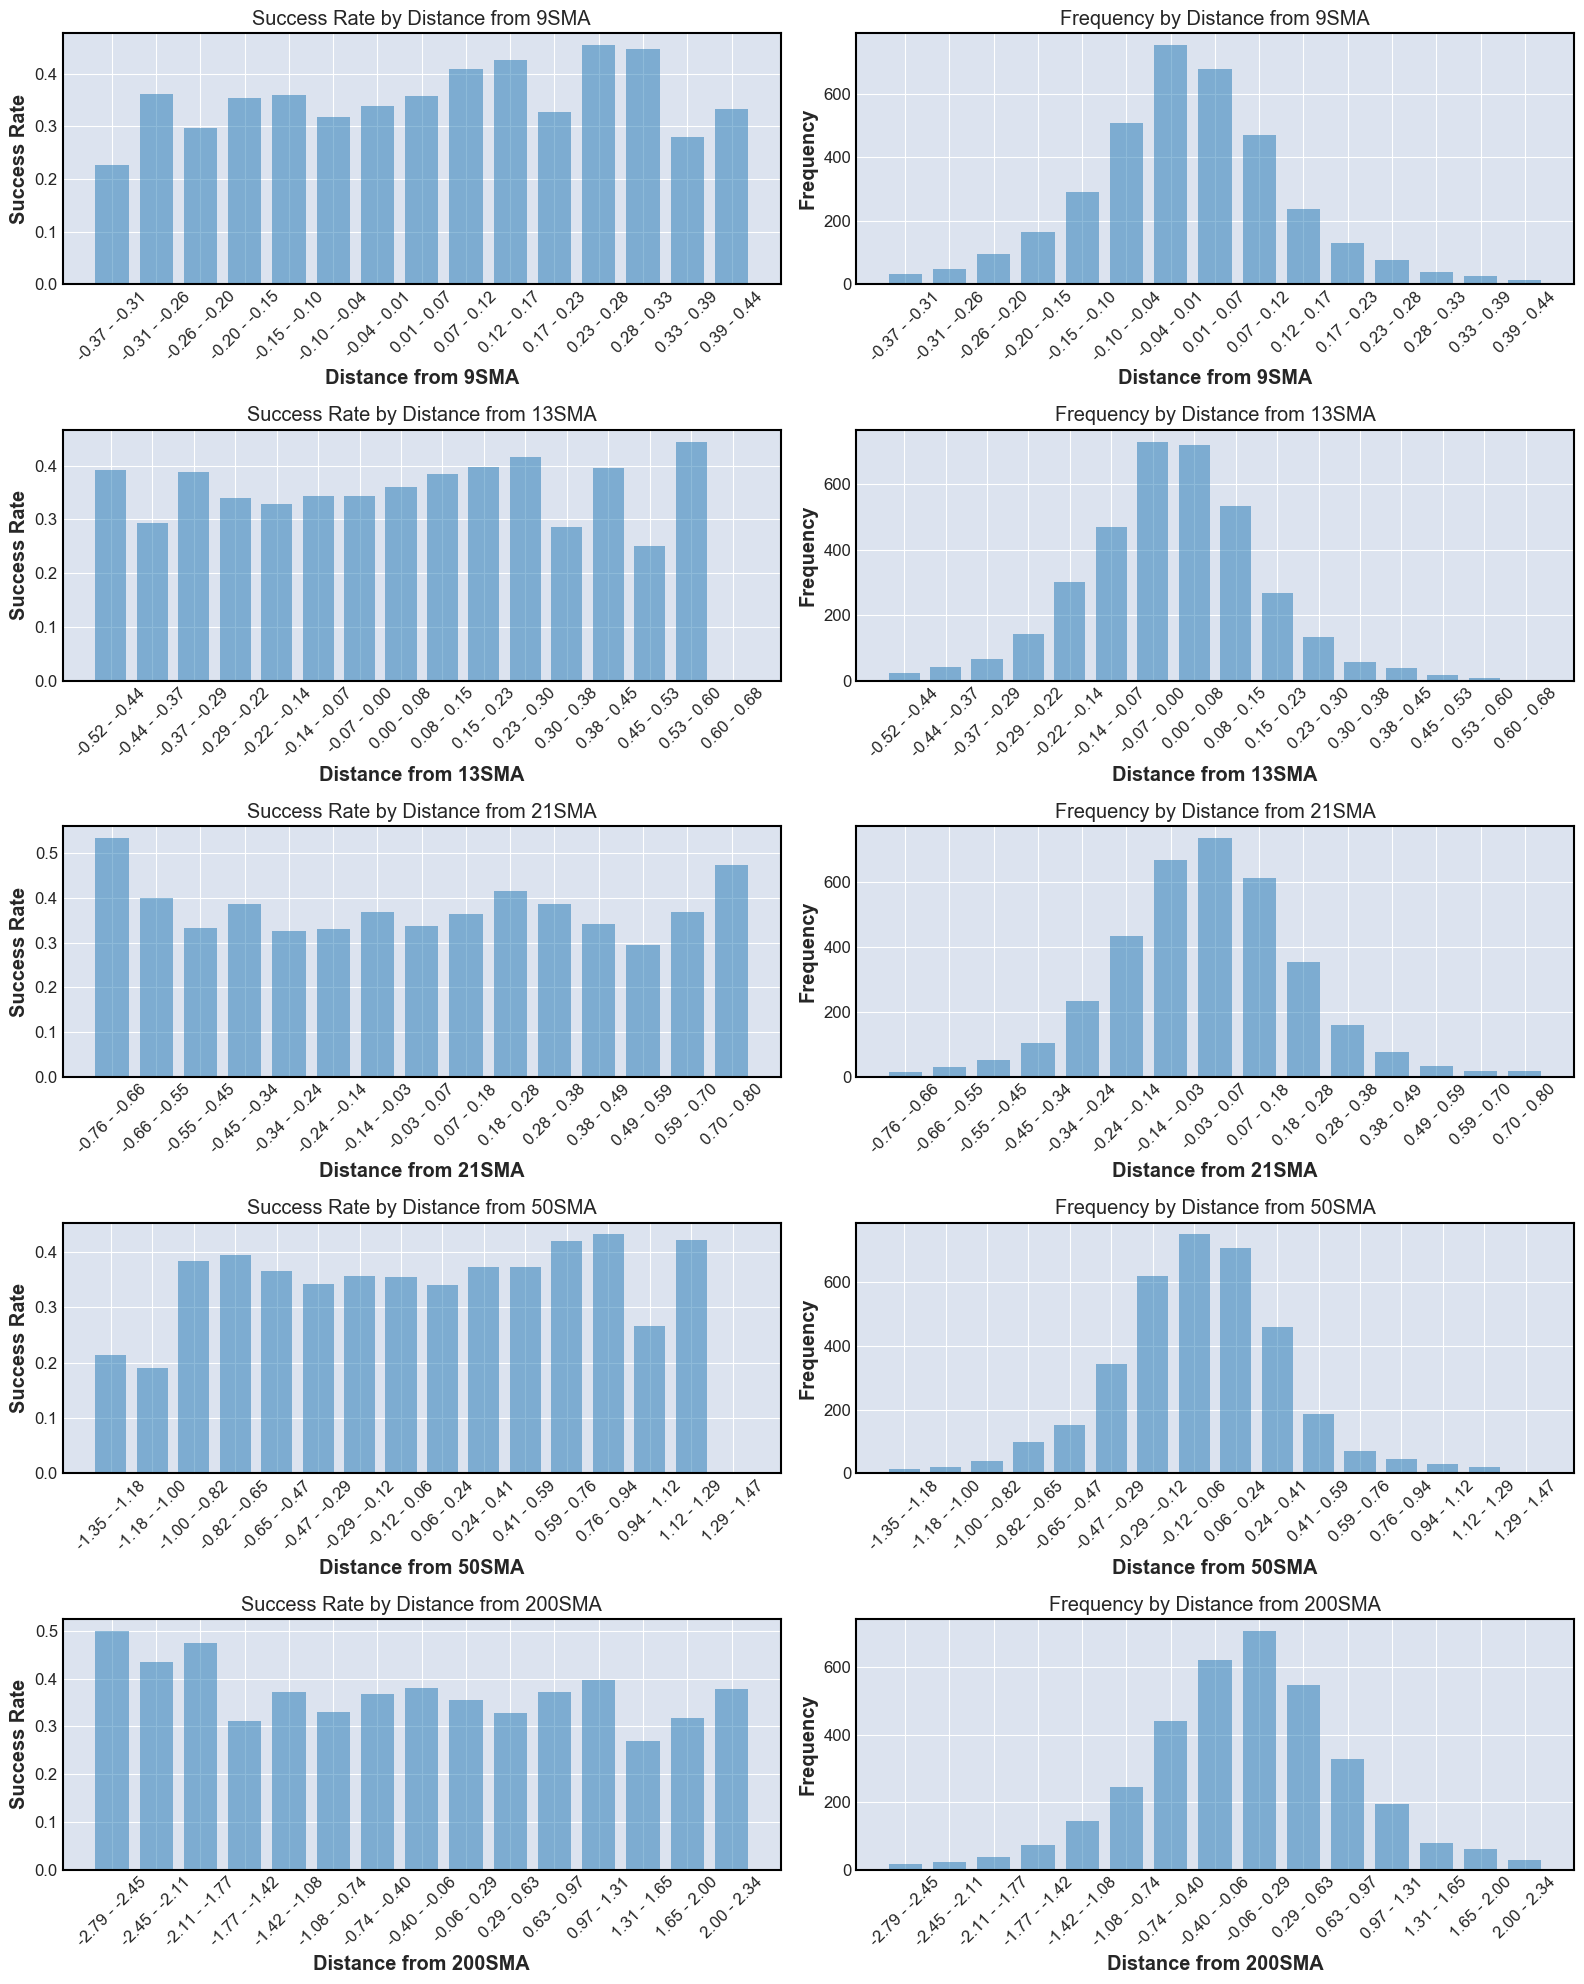

In [31]:
p_variable1 = 'Distance from 9SMA'
p_variable2 = 'Distance from 13SMA'
p_variable3 = 'Distance from 21SMA'
p_variable4 = 'Distance from 50SMA'
p_variable5 = 'Distance from 200SMA'
bins = 15
fig,ax = plt.subplots(5,2)
fig.set_size_inches(16, 20)
ax[0,0], bins00 = data_utils.plotBins(data_utils.removeOutliers(0.01,0.99,subset_df[subset_df['Directions']==-1],p_variable1),p_variable1,'Successes',ax[0,0],bins)
ax[0,1] = data_utils.plotHist(data_utils.removeOutliers(0.01,0.99,subset_df[subset_df['Directions']==-1],p_variable1),p_variable1,ax[0,1],bins00)
ax[1,0], bins10 = data_utils.plotBins(data_utils.removeOutliers(0.01,0.99,subset_df[subset_df['Directions']==-1],p_variable2),p_variable2,'Successes',ax[1,0],bins)
ax[1,1] = data_utils.plotHist(data_utils.removeOutliers(0.01,0.99,subset_df[subset_df['Directions']==-1],p_variable2),p_variable2,ax[1,1],bins10)
ax[2,0], bins20 = data_utils.plotBins(data_utils.removeOutliers(0.01,0.99,subset_df[subset_df['Directions']==-1],p_variable3),p_variable3,'Successes',ax[2,0],bins)
ax[2,1] = data_utils.plotHist(data_utils.removeOutliers(0.01,0.99,subset_df[subset_df['Directions']==-1],p_variable3),p_variable3,ax[2,1],bins20)
ax[3,0], bins30 = data_utils.plotBins(data_utils.removeOutliers(0.01,0.99,subset_df[subset_df['Directions']==-1],p_variable4),p_variable4,'Successes',ax[3,0],bins)
ax[3,1] = data_utils.plotHist(data_utils.removeOutliers(0.01,0.99,subset_df[subset_df['Directions']==-1],p_variable4),p_variable4,ax[3,1],bins30)
ax[4,0], bins40 = data_utils.plotBins(data_utils.removeOutliers(0.01,0.99,subset_df[subset_df['Directions']==-1],p_variable5),p_variable5,'Successes',ax[4,0],bins)
ax[4,1] = data_utils.plotHist(data_utils.removeOutliers(0.01,0.99,subset_df[subset_df['Directions']==-1],p_variable5),p_variable5,ax[4,1],bins40)
fig.tight_layout()

<b>Notes: </b>These plots above are showing the same information as in the previous figure, except the data is subset on only containing candlesticks where the associated trade is bearish. My intuition for this is that hanging man candlesticks are often seen as a trend reversal. Therefore, it makes sense that in some of the plots (like in the 9-period, 13-period, and 50-period plots), the success rates seem to be trending up from left to right. As the sayig goes, what goes goes up must come down, the farther above the moving averages the price rises, the more likely it may be that a trend reversal happens.<br>
I'm going to create three binary variables:<br>
- <b>Bearish9SMA</b> - takes a value of 1 if the Distance from 9SMA is greater than or equal to 0.06. Otherwise is 0.
- <b>Bearish 13SMA</b> - takes a value of 1 if the Distance from 13SMA is greater than or equal to 0.07. Otherwise is 0.
- <b>Bearish 50SMA</b> - takes a value of 1 if the Distance from 50SMA is greater than or equal to 0.23. Otherwise is 0.
Then, I will perform odds ratios tests to see if the success rates within each of these variables are significantly different. If any of them yield statistically significantly higher success rates, the variable with the highest difference will be kept and added to the data set.

In [32]:
bearish9SMA = subset_df[p_variable1][subset_df['Directions']==-1] >= 0.06
bearish9SMA = bearish9SMA.astype(int)
bearish13SMA = subset_df[p_variable2][subset_df['Directions']==-1] >= 0.07
bearish13SMA = bearish13SMA.astype(int)
bearish50SMA = subset_df[p_variable4][subset_df['Directions']==-1] >= 0.23
bearish50SMA = bearish50SMA.astype(int)

In [33]:
#now I need to create a table for the odds ratios computations
successes = subset_df['Successes'][subset_df['Directions']==-1]
var_set = [bearish9SMA,bearish13SMA,bearish50SMA]
table_rows = []
for v in var_set:
    l0 = len(v[v==0])
    s0 = sum(successes[list(v==0)])/l0
    l1 = len(v[v==1])
    s1 = sum(successes[list(v==1)])/l1
    table_rows.append([0,1,s0,s1,l0,l1])
new_table = pd.DataFrame(table_rows,index = ['Bearish9SMA','Bearish13SMA','Bearish50SMA'],columns=['Value 1','Value 2', 'Rate 1','Rate 2','Count 1','Count 2'])

In [34]:
#I am calling the getOddsRatio function that I wrote. I am passing in an alpha value of 0.05 which will correspond to a 95% confidence interval
ors, lower_cis, upper_cis = data_utils.getOddsRatios(new_table,0.05)
new_table['Odds Ratios'] = ors
new_table['Odds Lower Interval'] = lower_cis
new_table['Odds Upper Interval'] = upper_cis

In [35]:
table = table.append(new_table)

In [36]:
table

Value 1  Value 2    Rate 1    Rate 2  Count 1  Count 2  \
Bullish9SMA         0        1  0.356250  0.415435     2560      609   
Bullish13SMA        0        1  0.355407  0.472727     2839      330   
Bullish50SMA        0        1  0.360662  0.417526     2781      388   
Bearish9SMA         0        1  0.341052  0.401487     2548     1076   
Bearish13SMA        0        1  0.344603  0.389222     2455     1169   
Bearish50SMA        0        1  0.352771  0.378911     2761      863   

              Odds Ratios  Odds Lower Interval  Odds Upper Interval  
Bullish9SMA      1.284201             1.072305             1.537968  
Bullish13SMA     1.626055             1.292776             2.045254  
Bullish50SMA     1.270684             1.023728             1.577212  
Bearish9SMA      1.296071             1.119055             1.501088  
Bearish13SMA     1.211990             1.049392             1.399781  
Bearish50SMA     1.119305             0.955585             1.311076

<b>Bearish Hypothesis Conclusion:</b> Through the odds ratios and their 95% confidence intervals, two of the three engineered features appear to be significant in increasing the success rate. In particular, using the 9-period SMA as a trade entry criteria is the most significant. The odds ratio for this Bearish9SMA term can be interpretted as follows 'I am 95% confident that the success rate when trading bearish candles, using this criteria, yields a success rate on average between 1.12 and 1.5 times the success rate when trading the opposite of this criteria.' It is important to note that this range is more narrow than the range from the Bullish13SMA feature, which is due to the higher sample size of 1076 observations within this criteria.

In [37]:
#add the bearish9SMA variable to the dataframe.
subset_df['Bearish 9 SMA'] = [0]*subset_df.shape[0]
subset_df['Bearish 9 SMA'][subset_df['Directions']==-1] = bearish9SMA

C:\Users\david\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\david\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\david\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

## Hypothesis 2:
There exists trade conditions related to the size of the candlestick in relation to various moving candlestick size averages that yield statistically significantly higher success rates.

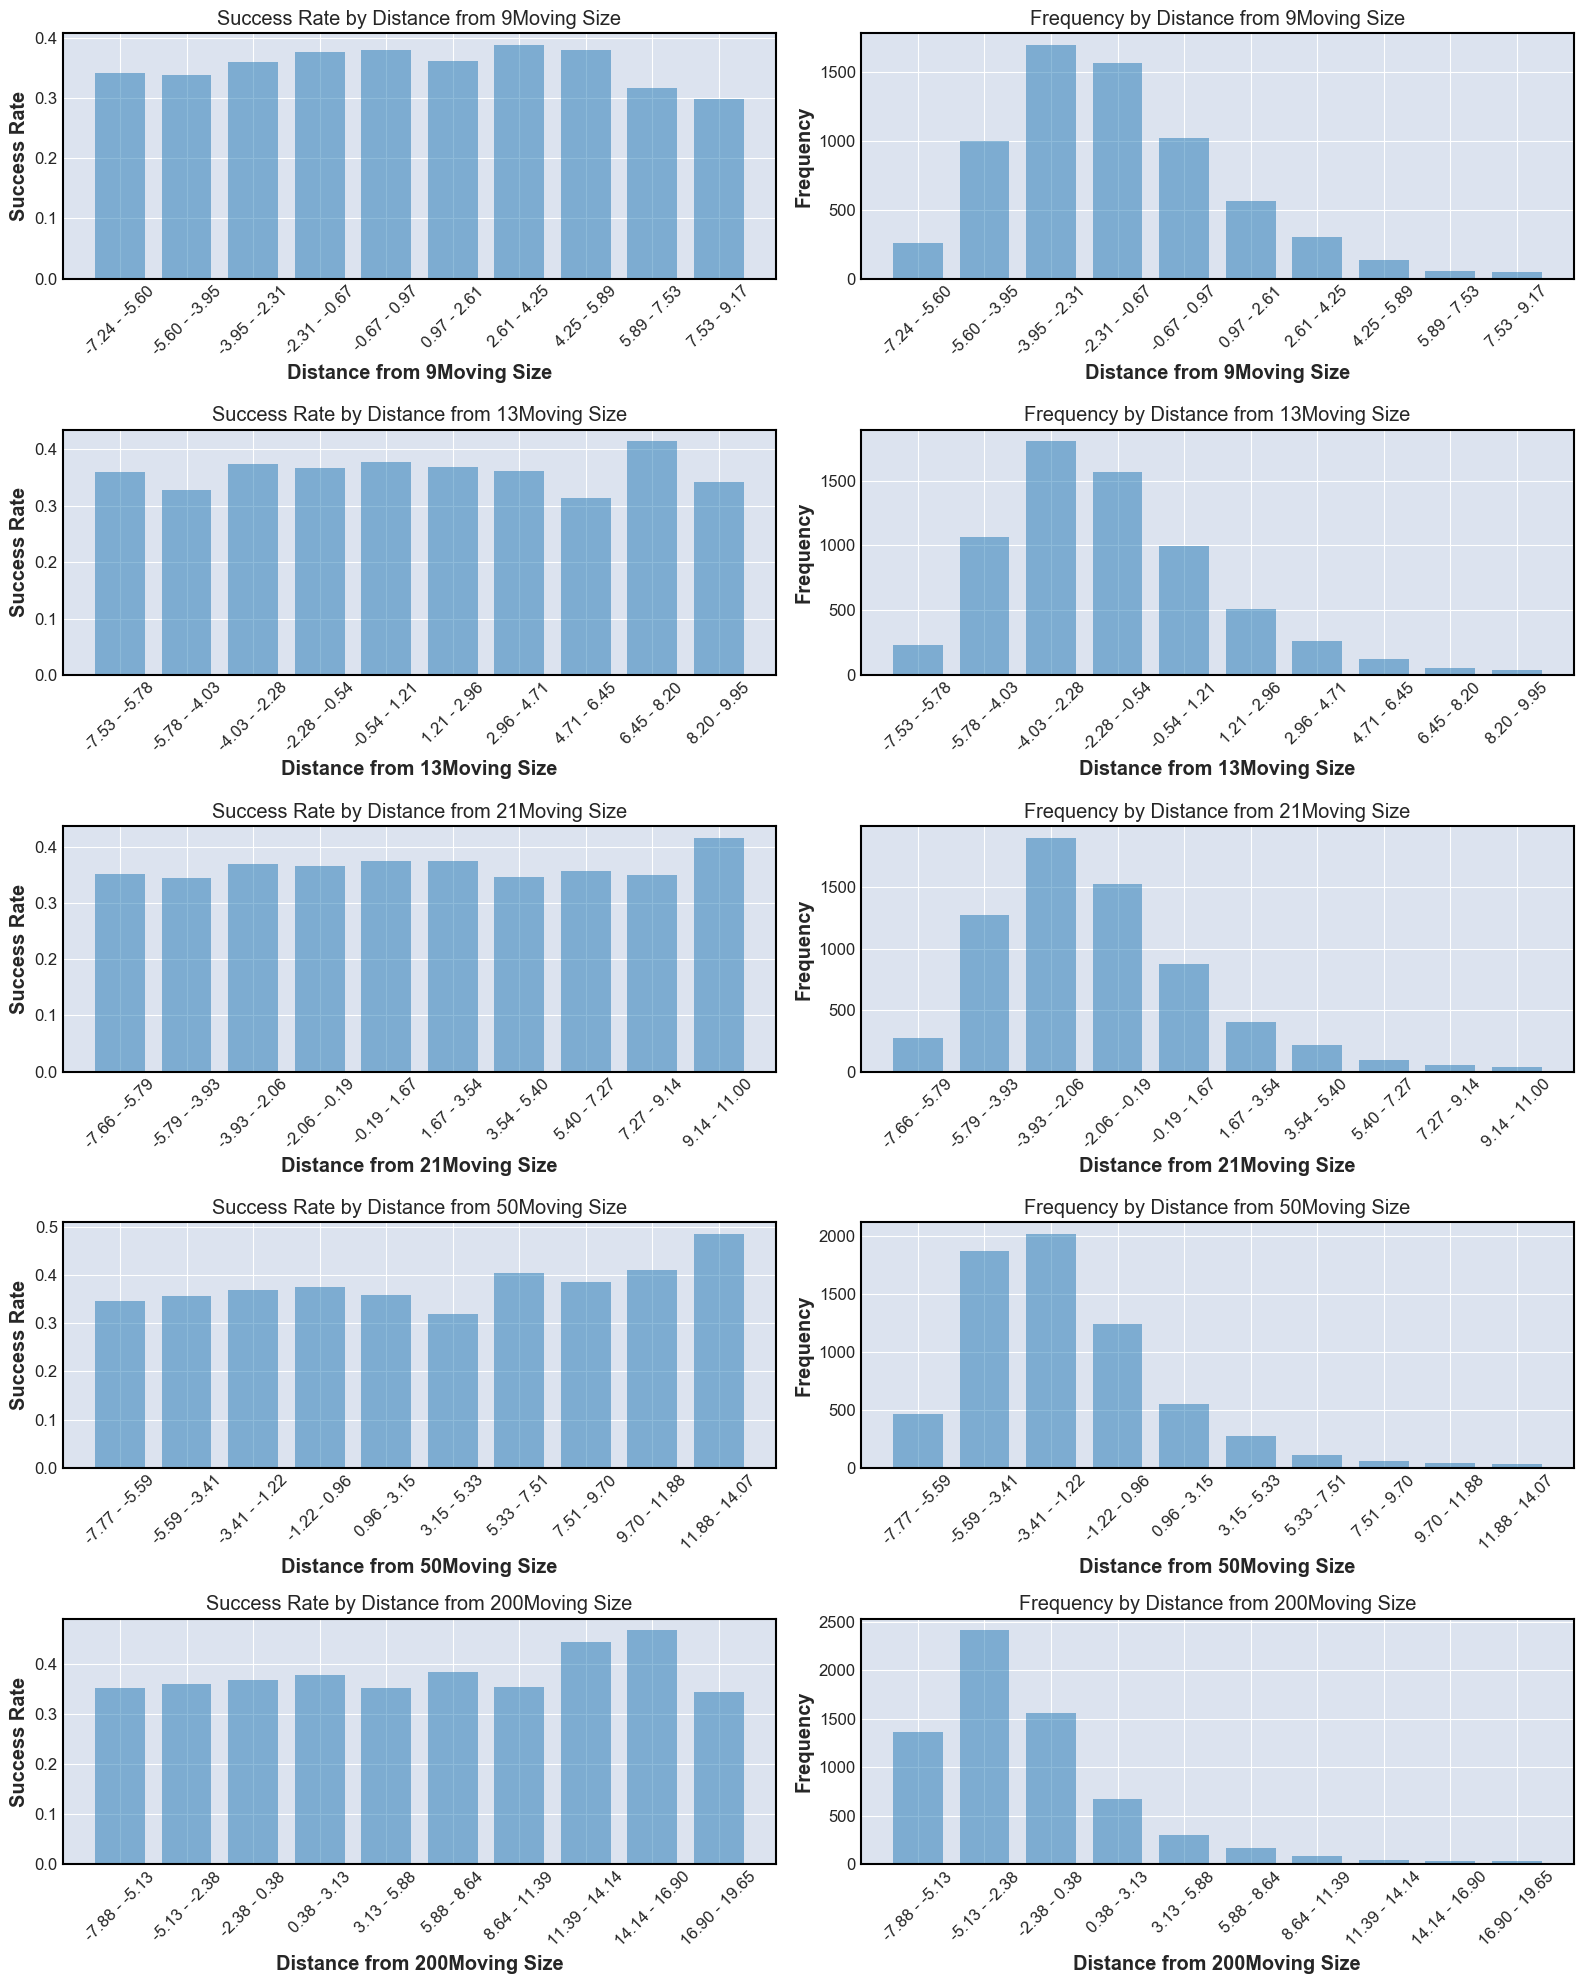

In [38]:
p_variable1 = 'Distance from 9Moving Size'
p_variable2 = 'Distance from 13Moving Size'
p_variable3 = 'Distance from 21Moving Size'
p_variable4 = 'Distance from 50Moving Size'
p_variable5 = 'Distance from 200Moving Size'
bins = 10
fig,ax = plt.subplots(5,2)
fig.set_size_inches(16, 20)
ax[0,0], bins00 = data_utils.plotBins(data_utils.removeOutliers(0.01,0.99,subset_df,p_variable1),p_variable1,'Successes',ax[0,0],bins)
ax[0,1] = data_utils.plotHist(data_utils.removeOutliers(0.01,0.99,subset_df,p_variable1),p_variable1,ax[0,1],bins00)
ax[1,0], bins10 = data_utils.plotBins(data_utils.removeOutliers(0.01,0.99,subset_df,p_variable2),p_variable2,'Successes',ax[1,0],bins)
ax[1,1] = data_utils.plotHist(data_utils.removeOutliers(0.01,0.99,subset_df,p_variable2),p_variable2,ax[1,1],bins10)
ax[2,0], bins20 = data_utils.plotBins(data_utils.removeOutliers(0.01,0.99,subset_df,p_variable3),p_variable3,'Successes',ax[2,0],bins)
ax[2,1] = data_utils.plotHist(data_utils.removeOutliers(0.01,0.99,subset_df,p_variable3),p_variable3,ax[2,1],bins20)
ax[3,0], bins30 = data_utils.plotBins(data_utils.removeOutliers(0.01,0.99,subset_df,p_variable4),p_variable4,'Successes',ax[3,0],bins)
ax[3,1] = data_utils.plotHist(data_utils.removeOutliers(0.01,0.99,subset_df,p_variable4),p_variable4,ax[3,1],bins30)
ax[4,0], bins40 = data_utils.plotBins(data_utils.removeOutliers(0.01,0.99,subset_df,p_variable5),p_variable5,'Successes',ax[4,0],bins)
ax[4,1] = data_utils.plotHist(data_utils.removeOutliers(0.01,0.99,subset_df,p_variable5),p_variable5,ax[4,1],bins40)
fig.tight_layout()

<b>Notes: </b>Overall, the success rates above look pretty uniform. The moving average period that yields the best pattern is the 50 period moving average. Therefore I will create the following binary variable and test the odds ratios.
- <b>Period50Size: </b>This feature will take a value of 1 if Distance from 50Moving Size is greater than or equal to 5.35. Otherwise it is 0.

In [39]:
Period50Size = subset_df[p_variable4] >= 5.35
Period50Size = Period50Size.astype(int)

In [40]:
#now I need to create a table for the odds ratios computations
successes = subset_df['Successes']
var_set = [Period50Size]
table_rows = []
for v in var_set:
    l0 = len(v[v==0])
    s0 = sum(successes[list(v==0)])/l0
    l1 = len(v[v==1])
    s1 = sum(successes[list(v==1)])/l1
    table_rows.append([0,1,s0,s1,l0,l1])
new_table = pd.DataFrame(table_rows,index = ['50 Period Size Range'],columns=['Value 1','Value 2', 'Rate 1','Rate 2','Count 1','Count 2'])

In [41]:
#I am calling the getOddsRatio function that I wrote. I am passing in an alpha value of 0.05 which will correspond to a 95% confidence interval
ors, lower_cis, upper_cis = data_utils.getOddsRatios(new_table,0.05)
new_table['Odds Ratios'] = ors
new_table['Odds Lower Interval'] = lower_cis
new_table['Odds Upper Interval'] = upper_cis

In [42]:
table = table.append(new_table)

In [43]:
table

Value 1  Value 2    Rate 1    Rate 2  Count 1  Count 2  \
Bullish9SMA                 0        1  0.356250  0.415435     2560      609   
Bullish13SMA                0        1  0.355407  0.472727     2839      330   
Bullish50SMA                0        1  0.360662  0.417526     2781      388   
Bearish9SMA                 0        1  0.341052  0.401487     2548     1076   
Bearish13SMA                0        1  0.344603  0.389222     2455     1169   
Bearish50SMA                0        1  0.352771  0.378911     2761      863   
50 Period Size Range        0        1  0.360961  0.407285     6491      302   

                      Odds Ratios  Odds Lower Interval  Odds Upper Interval  
Bullish9SMA              1.284201             1.072305             1.537968  
Bullish13SMA             1.626055             1.292776             2.045254  
Bullish50SMA             1.270684             1.023728             1.577212  
Bearish9SMA              1.296071             1.119055             1.501088  
Bearish13SMA             1.211990             1.049392             1.399781  
Bearish50SMA             1.119305             0.955585             1.311076  
50 Period Size Range     1.216518             0.961677             1.538891

<b>Hypothesis Conclusion:</b> Through the odds ratio and its 95% confidence interval, the engineered feature appears to not be significant in increasing the success rate. This is apparent because 1 is contained within the confidence interval. This feature is not significant so will not be added to the data.

## Hypothesis 3:
There exists trade conditions related to the relative stock volatility that yields statistically significantly higher success rates.

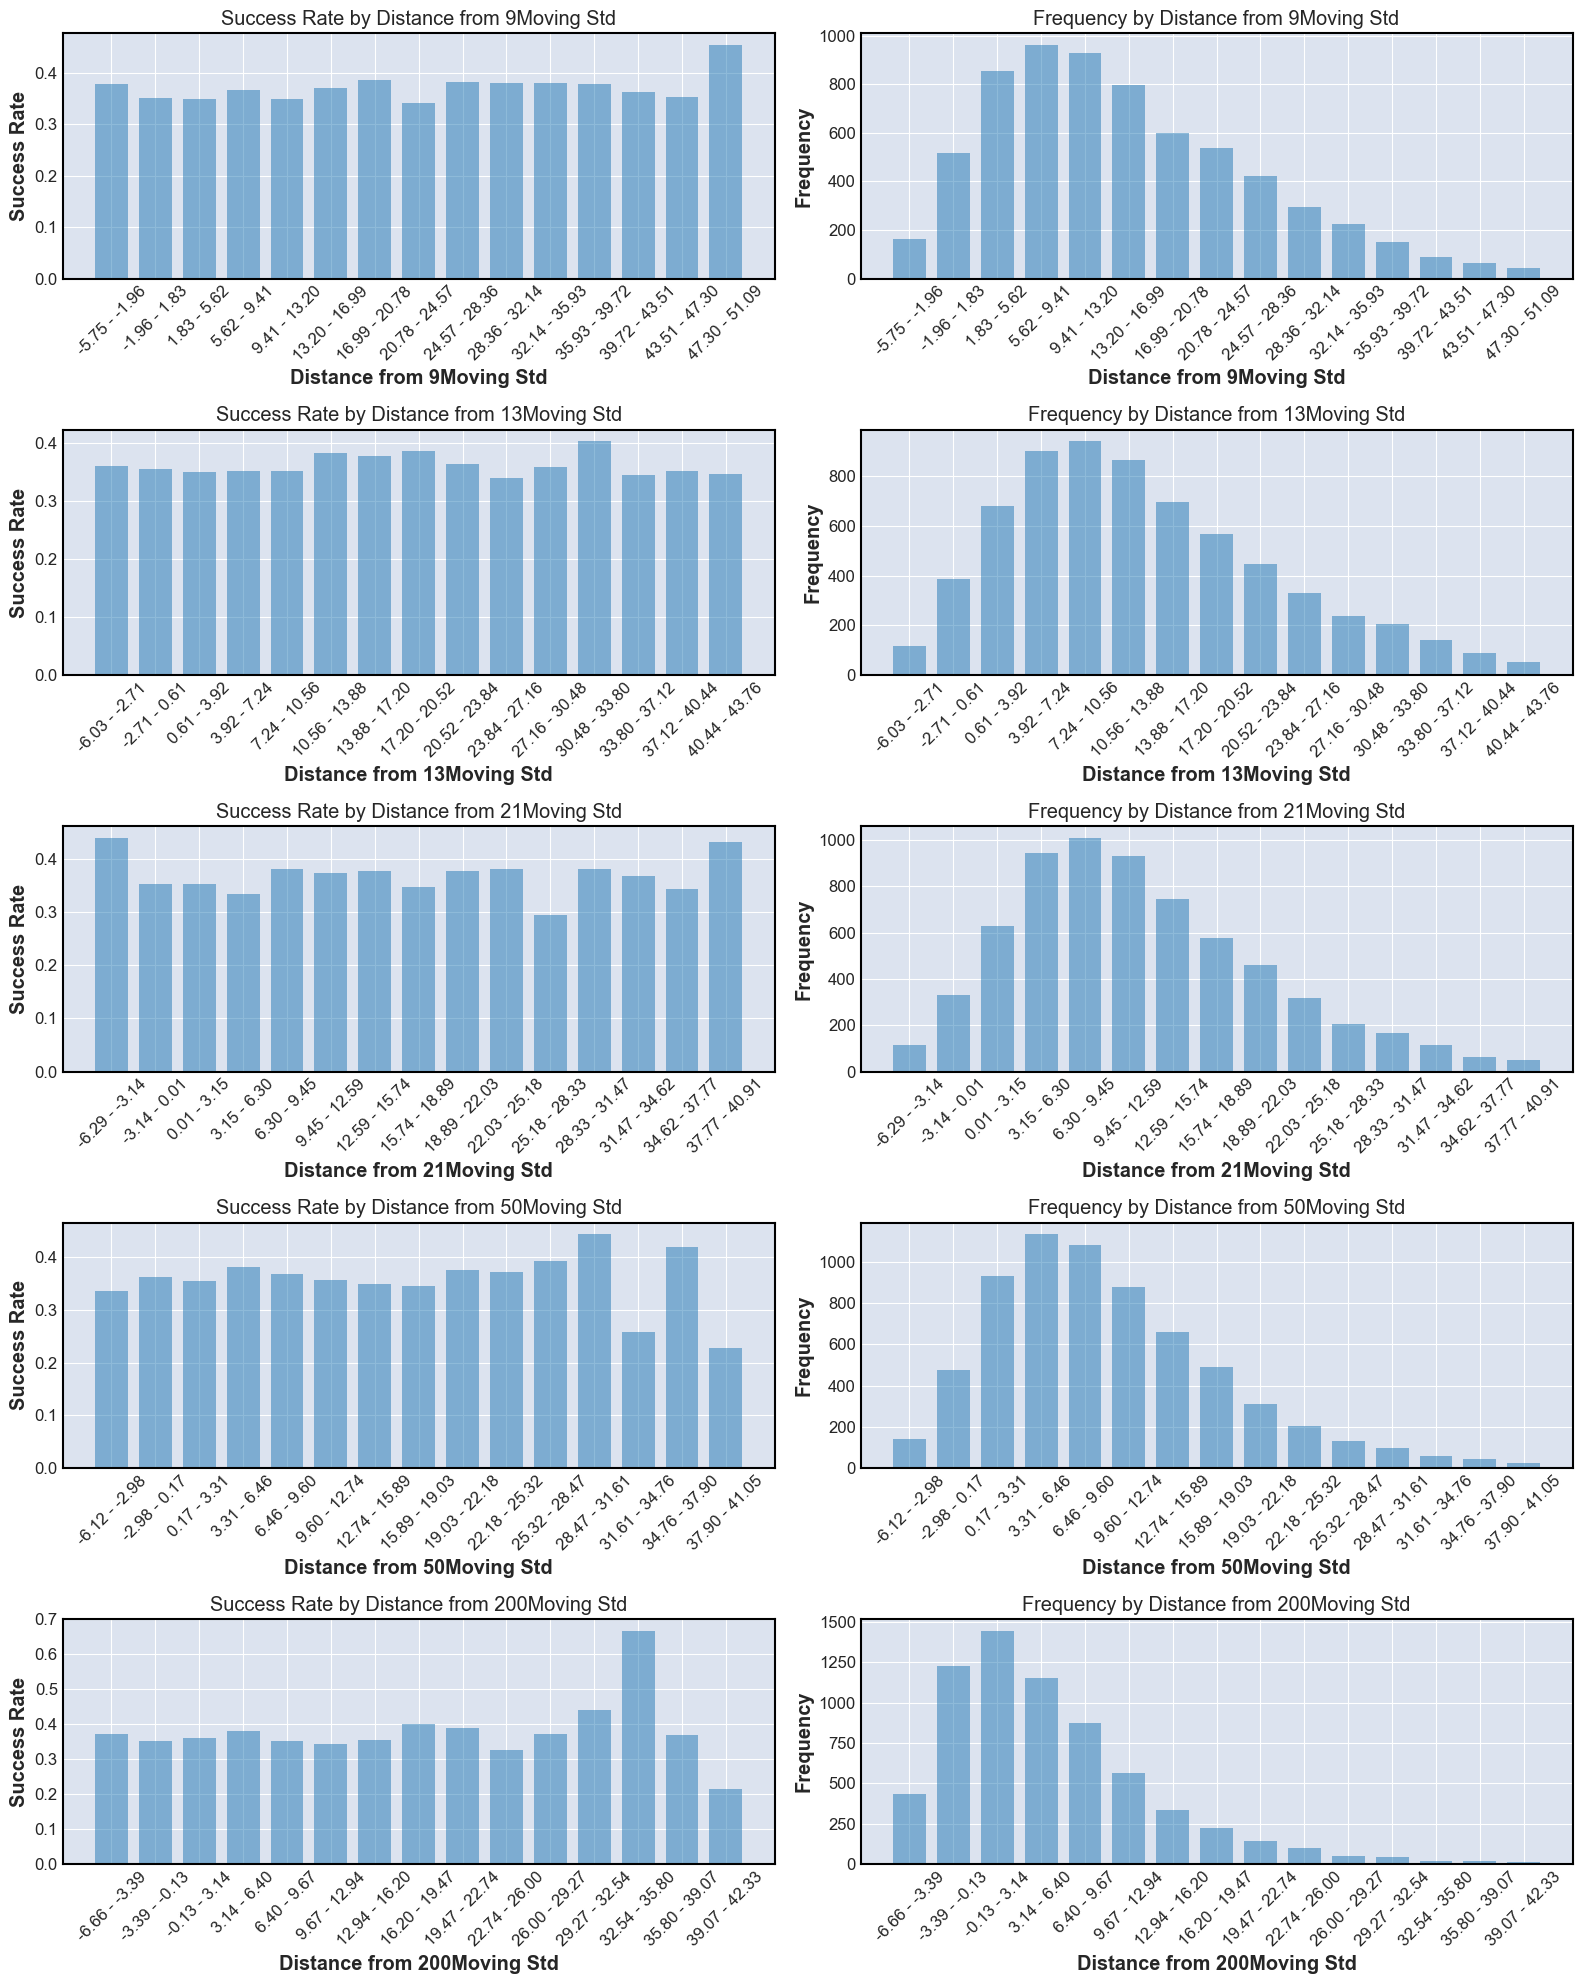

In [44]:
p_variable1 = 'Distance from 9Moving Std'
p_variable2 = 'Distance from 13Moving Std'
p_variable3 = 'Distance from 21Moving Std'
p_variable4 = 'Distance from 50Moving Std'
p_variable5 = 'Distance from 200Moving Std'
bins = 15
fig,ax = plt.subplots(5,2)
fig.set_size_inches(16, 20)
ax[0,0], bins00 = data_utils.plotBins(data_utils.removeOutliers(0.01,0.99,subset_df,p_variable1),p_variable1,'Successes',ax[0,0],bins)
ax[0,1] = data_utils.plotHist(data_utils.removeOutliers(0.01,0.99,subset_df,p_variable1),p_variable1,ax[0,1],bins00)
ax[1,0], bins10 = data_utils.plotBins(data_utils.removeOutliers(0.01,0.99,subset_df,p_variable2),p_variable2,'Successes',ax[1,0],bins)
ax[1,1] = data_utils.plotHist(data_utils.removeOutliers(0.01,0.99,subset_df,p_variable2),p_variable2,ax[1,1],bins10)
ax[2,0], bins20 = data_utils.plotBins(data_utils.removeOutliers(0.01,0.99,subset_df,p_variable3),p_variable3,'Successes',ax[2,0],bins)
ax[2,1] = data_utils.plotHist(data_utils.removeOutliers(0.01,0.99,subset_df,p_variable3),p_variable3,ax[2,1],bins20)
ax[3,0], bins30 = data_utils.plotBins(data_utils.removeOutliers(0.01,0.99,subset_df,p_variable4),p_variable4,'Successes',ax[3,0],bins)
ax[3,1] = data_utils.plotHist(data_utils.removeOutliers(0.01,0.99,subset_df,p_variable4),p_variable4,ax[3,1],bins30)
ax[4,0], bins40 = data_utils.plotBins(data_utils.removeOutliers(0.01,0.99,subset_df,p_variable5),p_variable5,'Successes',ax[4,0],bins)
ax[4,1] = data_utils.plotHist(data_utils.removeOutliers(0.01,0.99,subset_df,p_variable5),p_variable5,ax[4,1],bins40)
fig.tight_layout()

All of these success rate plots look pretty uniform. The exception is the plot of the 200Moving Std which has a spike in success rate at the right. However, this spike is occurring on a low frequency bar, so it doesn't seem important to me.

<b>Hypothesis Conclusion: </b>The success rate is uniform across different measures of volatility.

## Hypothesis 4:
There exists trade conditions related to how far from normal the volume is that yields statistically significantly higher success rates.

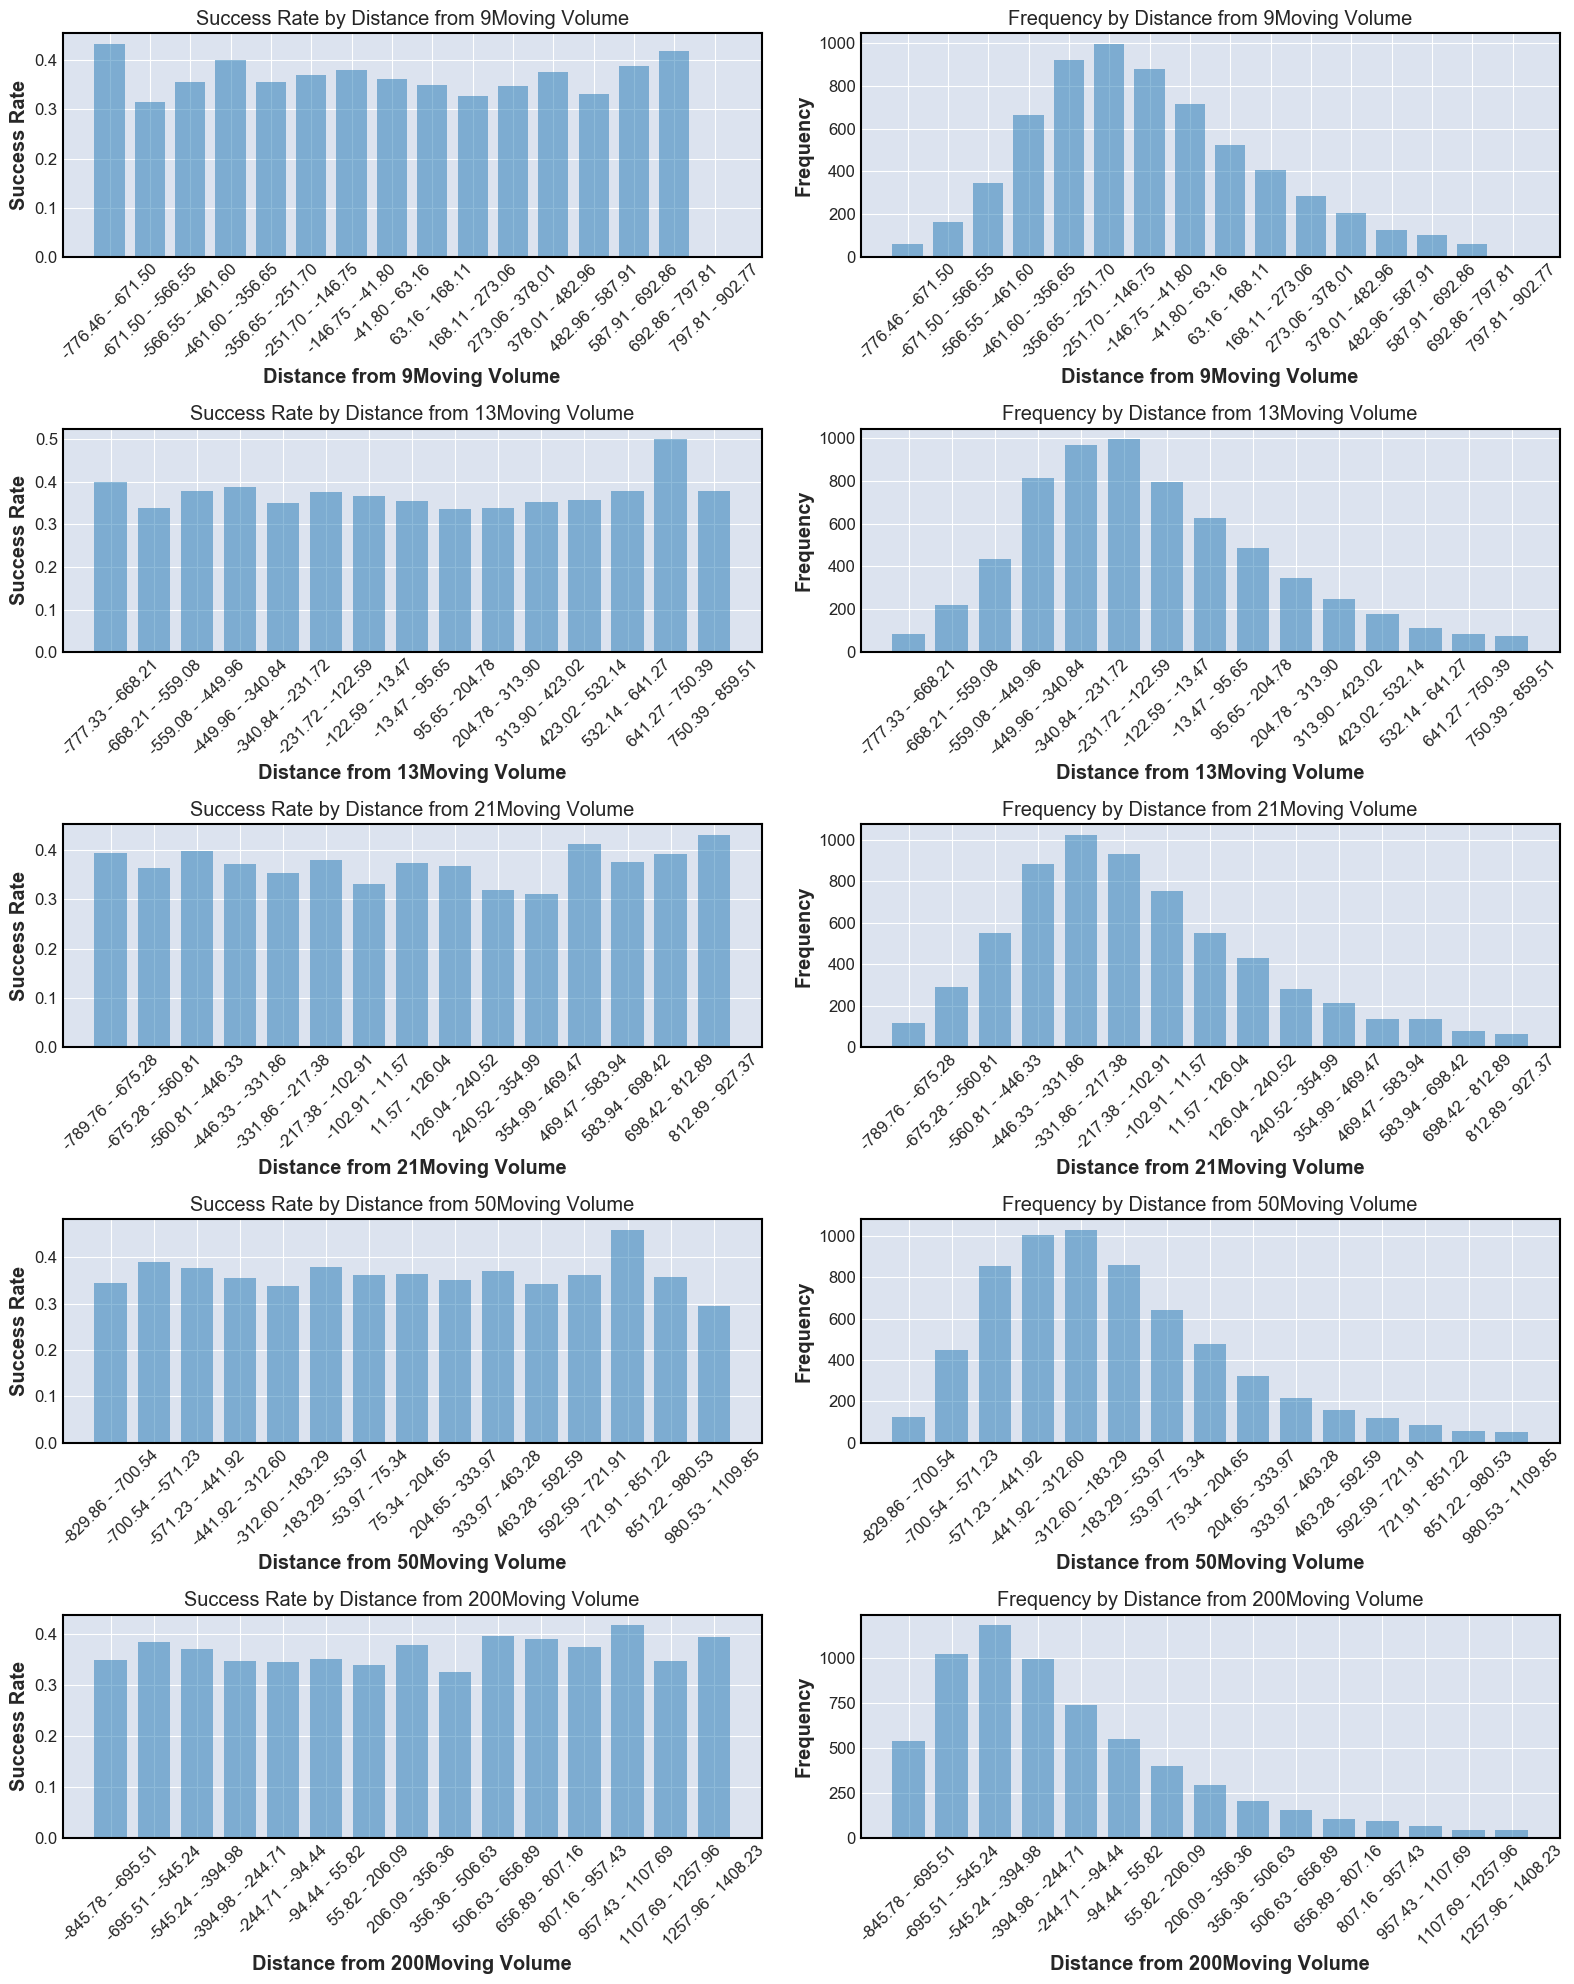

In [45]:
p_variable1 = 'Distance from 9Moving Volume'
p_variable2 = 'Distance from 13Moving Volume'
p_variable3 = 'Distance from 21Moving Volume'
p_variable4 = 'Distance from 50Moving Volume'
p_variable5 = 'Distance from 200Moving Volume'
bins = 15
fig,ax = plt.subplots(5,2)
fig.set_size_inches(16, 20)
ax[0,0], bins00 = data_utils.plotBins(data_utils.removeOutliers(0.01,0.96,subset_df,p_variable1),p_variable1,'Successes',ax[0,0],bins)
ax[0,1] = data_utils.plotHist(data_utils.removeOutliers(0.01,0.96,subset_df,p_variable1),p_variable1,ax[0,1],bins00)
ax[1,0], bins10 = data_utils.plotBins(data_utils.removeOutliers(0.01,0.96,subset_df,p_variable2),p_variable2,'Successes',ax[1,0],bins)
ax[1,1] = data_utils.plotHist(data_utils.removeOutliers(0.01,0.96,subset_df,p_variable2),p_variable2,ax[1,1],bins10)
ax[2,0], bins20 = data_utils.plotBins(data_utils.removeOutliers(0.01,0.96,subset_df,p_variable3),p_variable3,'Successes',ax[2,0],bins)
ax[2,1] = data_utils.plotHist(data_utils.removeOutliers(0.01,0.96,subset_df,p_variable3),p_variable3,ax[2,1],bins20)
ax[3,0], bins30 = data_utils.plotBins(data_utils.removeOutliers(0.01,0.96,subset_df,p_variable4),p_variable4,'Successes',ax[3,0],bins)
ax[3,1] = data_utils.plotHist(data_utils.removeOutliers(0.01,0.96,subset_df,p_variable4),p_variable4,ax[3,1],bins30)
ax[4,0], bins40 = data_utils.plotBins(data_utils.removeOutliers(0.01,0.96,subset_df,p_variable5),p_variable5,'Successes',ax[4,0],bins)
ax[4,1] = data_utils.plotHist(data_utils.removeOutliers(0.01,0.96,subset_df,p_variable5),p_variable5,ax[4,1],bins40)
fig.tight_layout()

All of the success rate plots look pretty uniformly distributed. There doesn't appear to be enough potential for engineering extra features from this.

<b>Hypothesis Conclusion: </b>The success rate is uniform across different measures of volume.

# Applying the Data and Hypothesis Insights to a Classification Decision Tree

In [46]:
#Since Bullish 13 SMA and Bearish 9 SMA are directionally dependent, I want to make a new column that has both (since they won't overlap)
#This should be more useful in doing modeling than using the two features independently
subset_df['Main SMA Indicator'] = [np.nan]*subset_df.shape[0]
subset_df['Main SMA Indicator'][subset_df['Directions']==1] = subset_df['Bullish 13 SMA'][subset_df['Directions']==1]
subset_df['Main SMA Indicator'][subset_df['Directions']==-1] = subset_df['Bearish 9 SMA'][subset_df['Directions']==-1]

C:\Users\david\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\david\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\david\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata

In [47]:
#first, I want to split the data of interest into both a training and test set
vars_of_interest = ['Main SMA Indicator','Distance from 13SMA','Distance from 9SMA','Distance from 21Moving Std',
                   'Distance from 50Moving Size','Distance from 13Moving Volume']

I am preparing a split of training and test data and then fitting a standard scaler object (used to scale the variables values to each have a mean of 0 and a standard deviation of 1) and using it to transform both the training and test sets. When applying data to a decision tree, the data isn't required to be scaled, but for good habit I am scaling it.<br>
The training and test data split is required because the training data will be used to build the model, and the test data will be used to validate it's strength.

In [48]:
X_train, X_test = train_test_split(subset_df[vars_of_interest+['Successes']], test_size = 0.075,random_state=10082020)

In [49]:
scaling = StandardScaler()
scaling = scaling.fit(X_train[vars_of_interest])
x_scaled = scaling.transform(X_train[vars_of_interest])
xtest_scaled = scaling.transform(X_test[vars_of_interest])
y = X_train['Successes']
y_test = X_test['Successes']

In [50]:
#getting the scaled data into a dataframen for my ease of use later on
X = pd.DataFrame(x_scaled,columns=vars_of_interest)
X_test = pd.DataFrame(xtest_scaled,columns=vars_of_interest)

First, I don't know how large the tree will need to be in terms of max leaf nodes. Therefore, I'll test out how different numbers of max leaf nodes impacts the accuracy, precision, and recall.

In [51]:
tree_metrics = []
for i in range(2,40):
    trading_tree = tree.DecisionTreeClassifier(max_leaf_nodes=i)
    tree_metric = data_utils.performValidations(X,y,[list(X.columns)],10,trading_tree)
    tree_metrics.append(tree_metric[0])

In [52]:
tree_precision, tree_recall, tree_acc = data_utils.getMetricSummaries(tree_metrics)

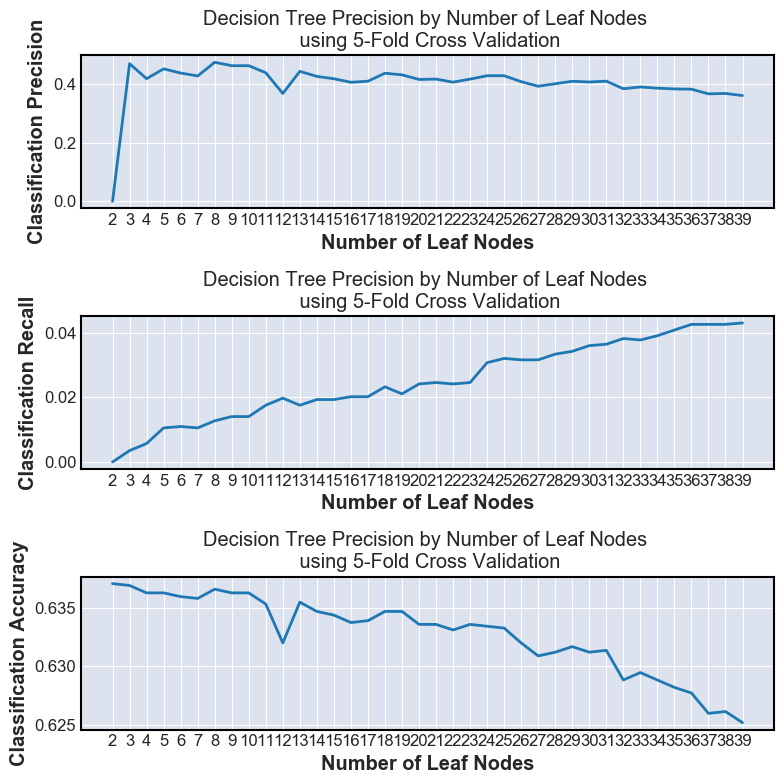

In [53]:
fig, ax = plt.subplots(3,1)
fig.set_size_inches(8, 8)
ax[0].plot(np.arange(2,40,1),tree_precision)
ax[0].set_title("Decision Tree Precision by Number of Leaf Nodes \n using 5-Fold Cross Validation")
ax[0].set_xlabel("Number of Leaf Nodes")
ax[0].set_ylabel("Classification Precision")
ax[0].set_xticks(np.arange(2,40,1))
ax[1].plot(np.arange(2,40,1),tree_recall)
ax[1].set_title("Decision Tree Precision by Number of Leaf Nodes \n using 5-Fold Cross Validation")
ax[1].set_xlabel("Number of Leaf Nodes")
ax[1].set_ylabel("Classification Recall")
ax[1].set_xticks(np.arange(2,40,1))
ax[2].plot(np.arange(2,40,1),tree_acc)
ax[2].set_title("Decision Tree Precision by Number of Leaf Nodes \n using 5-Fold Cross Validation")
ax[2].set_xlabel("Number of Leaf Nodes")
ax[2].set_ylabel("Classification Accuracy")
ax[2].set_xticks(np.arange(2,40,1))
fig.tight_layout()

The precision seems to be maxed out with only 3 leaf nodes in the tree. I am choosing this simple tree due to it's high precision and simplicity, which will help reduce the potential for overfitting (a highly complicated decision tree will often fit the training data too well, and it won't generalize well to new data sets).

[Text(697.5, 962.5, 'Main SMA Indicator <= 0.722\ngini = 0.462\nsamples = 6283\nvalue = [4003, 2280]'),
 Text(465.0, 577.5, 'Distance from 21Moving Std <= 3.587\ngini = 0.454\nsamples = 4981\nvalue = [3245, 1736]'),
 Text(232.5, 192.5, 'gini = 0.454\nsamples = 4972\nvalue = [3243, 1729]'),
 Text(697.5, 192.5, 'gini = 0.346\nsamples = 9\nvalue = [2, 7]'),
 Text(930.0, 577.5, 'gini = 0.486\nsamples = 1302\nvalue = [758, 544]')]

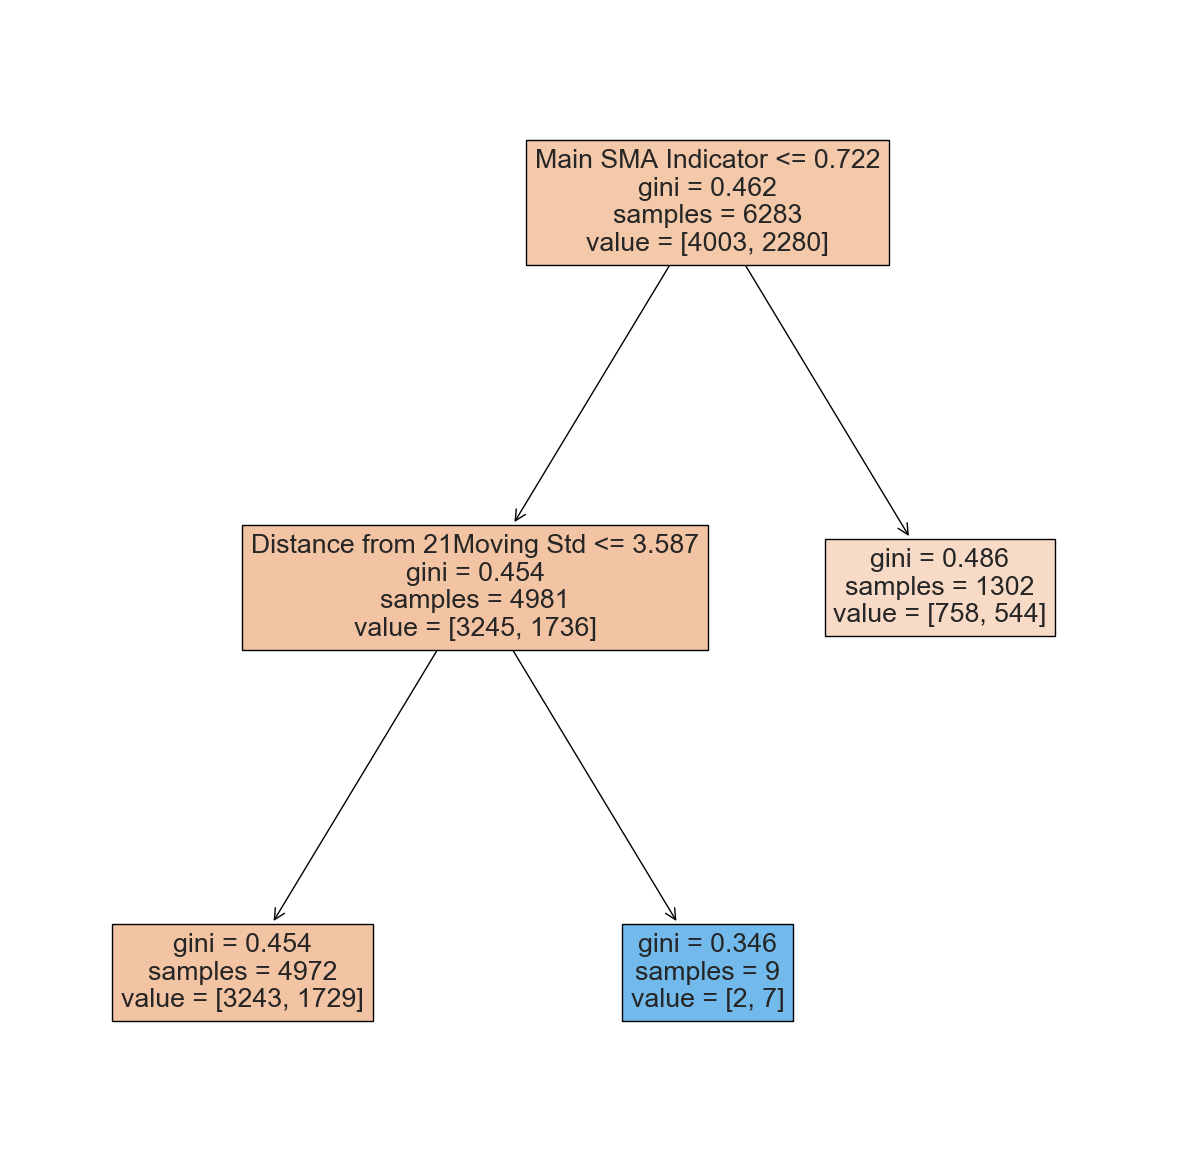

In [54]:
trading_tree = tree.DecisionTreeClassifier(max_leaf_nodes=3)
trading_tree.fit(X,y)
fig = plt.figure(figsize= (15,15))
tree.plot_tree(trading_tree,
   feature_names= vars_of_interest,
   filled=True)

The most important features for classifying an instance of a hanging man candlestick as a success is the derived feature 'Main SMA Indicator' and how volatile the stock is at the moment of the hanging man candlestick.

## Evaluating the Metrics from the Decision Tree

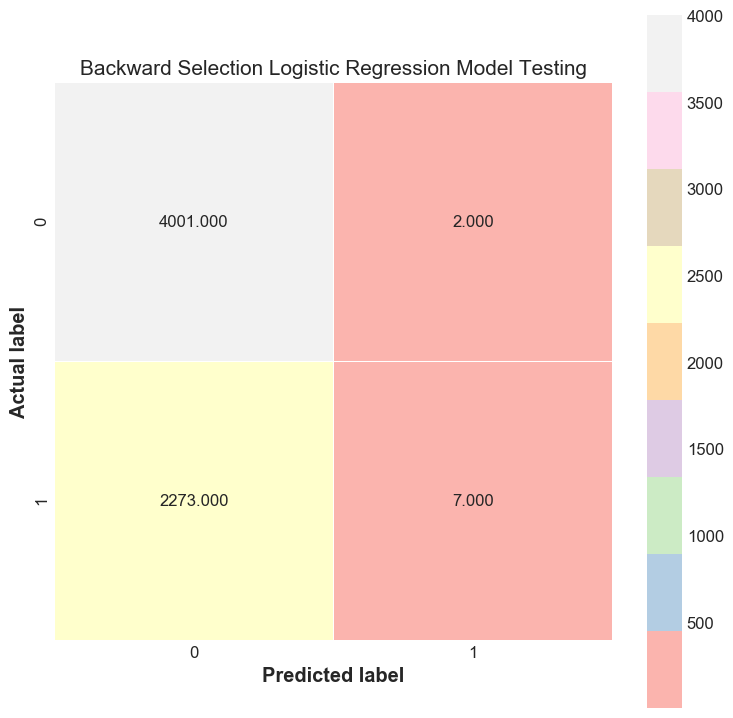

Accuracy = 0.6379118255610378
Precision = 0.7777777777777778
Recall = 0.0030701754385964912


In [57]:
#creating predictions of the test data
predictions = trading_tree.predict(X)

#getting the test metrics
cm = metrics.confusion_matrix(y, predictions)

#deriving the accuracy, precision, and recall
test_acc = (cm[0][0]+cm[1][1])/(sum(cm[0])+sum(cm[1]))
test_prec = cm[1][1]/(cm[1][1]+cm[0][1])
test_rec = cm[1][1]/(cm[1][0]+cm[1][1])
#plotting the metrics
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Pastel1');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title("Backward Selection Logistic Regression Model Testing", size = 15);
plt.show()

print("Accuracy = " +str(test_acc))
print("Precision = "+str(test_prec))
print("Recall = "+str(test_rec))

This tree has good precision for this data set, but the recall is extremely low. This may be due to the fact that the probability of success under many conditions of the trees is lower than 0.5, so I would like to check out a precision recall curve to see how the precision and recall change when the classification threshold strays from the default of 0.5.

In [58]:
y_scores_l2 = cross_val_predict(trading_tree,X,y,cv=5,method='predict_proba')
y_scores_l2 = [item[1] for item in y_scores_l2]

In [61]:
precisions, recalls, thresholds = precision_recall_curve(y, y_scores_l2)

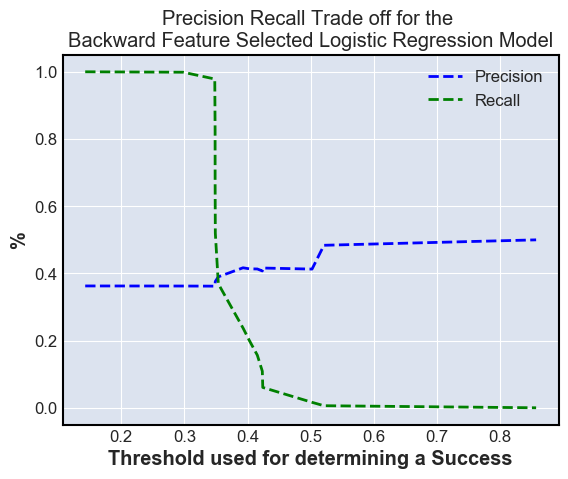

In [68]:
plt.plot(thresholds, precisions[:-1],'b--',label='Precision')
plt.plot(thresholds, recalls[:-1],'g--',label='Recall')
plt.legend()
plt.xlabel("Threshold used for determining a Success")
plt.ylabel("%")
plt.title("Precision Recall Trade off for the \nBackward Feature Selected Logistic Regression Model")
plt.show()

## Estimating the best threshold parameter to maximize trading profits.
This can be modeled with the equation:
### E (Payout) = P (Success) * E (Winning Trade) - P (Failure) * E (Losing Trade)
where E() is expected value and P() is probability.
In our case:
- P(Success) = Precision because precision is how many of the estimated winning trades are winners.
- P(Failure) = 1 - Precision
- E(Winning Trade) = 1.75 R where R is a predetermined maximum loss (the value of 1.75 was set at the beginning of the notebook as the variable "s1"). Using the stop loss and the price per share, you can buy a number of shares so that if the stop loss is triggered, you lose R.
- E(Losing Trade) = R <br>
Next, recall is the % of actual winning trades that are likely to be predicted using this model. Therefore, the E (Payout) will get multiplied by a function of recall, because a confident prediction isn't useful if it happens rarely in this scenario. I will create a scenario where there are 1,000 winning trades, so that E (payout) will get multiplied by [1,000 * recall%] which is the theoretical number of trades you take when following the model.

In [63]:
winnings = 1000*recalls[:-1]*(precisions[:-1] * np.array([1.75]*len(precisions[:-1])) - (1-precisions[:-1]))

In [64]:
#$R*max(winnings) is how much you would expect to profit using this strategy with the optimized classification over the 
#course of time it takes for 1,000 winning trades to occur (you are only participating in recall * 1000 of them though)
max(winnings)

34.83502024291497

In [65]:
print('Optimized Precision is '+str(precisions[np.argmax(winnings)]))
print('Optimized Recall is '+str(recalls[np.argmax(winnings)]))
print('These values are acheived using a threshold of '+str(thresholds[np.argmax(winnings)]))

Optimized Precision is 0.4169230769230769
Optimized Recall is 0.23771929824561402
These values are acheived using a threshold of 0.39285714285714285


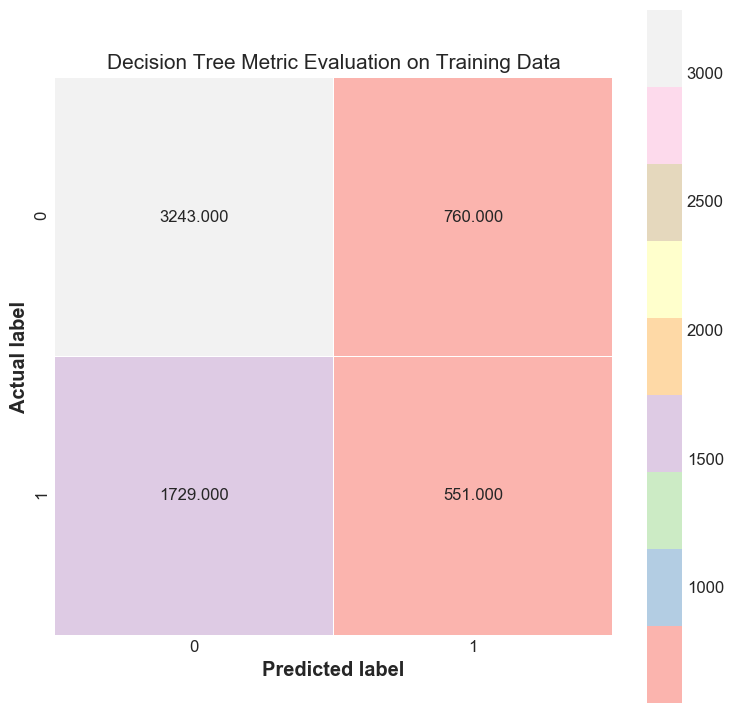

Accuracy = 0.6038516632182078
Precision = 0.42028985507246375
Recall = 0.24166666666666667


In [66]:
#creating predictions of the test data
predictions = (trading_tree.predict_proba(X)[:,1] >= thresholds[np.argmax(winnings)]).astype(bool)

#getting the test metrics
cm = metrics.confusion_matrix(y, predictions)

#deriving the accuracy, precision, and recall
test_acc = (cm[0][0]+cm[1][1])/(sum(cm[0])+sum(cm[1]))
test_prec = cm[1][1]/(cm[1][1]+cm[0][1])
test_rec = cm[1][1]/(cm[1][0]+cm[1][1])
#plotting the metrics
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Pastel1');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title("Decision Tree Metric Evaluation on Training Data", size = 15);
plt.show()

print("Accuracy = " +str(test_acc))
print("Precision = "+str(test_prec))
print("Recall = "+str(test_rec))

# Now to try out the Decision Tree on the Test Data

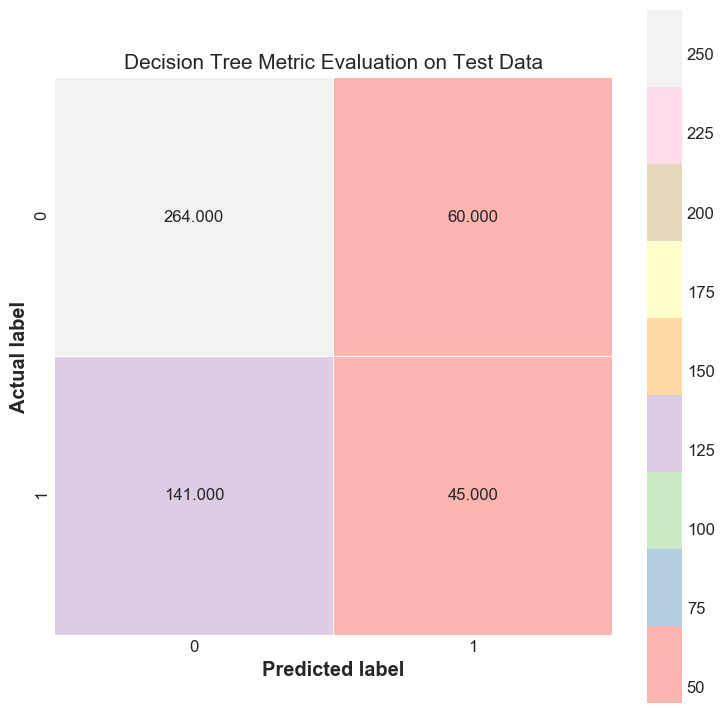

Accuracy = 0.6058823529411764
Precision = 0.42857142857142855
Recall = 0.24193548387096775


In [67]:
#creating predictions of the test data
predictions = (trading_tree.predict_proba(X_test)[:,1] >= thresholds[np.argmax(winnings)]).astype(bool)

#getting the test metrics
cm = metrics.confusion_matrix(y_test, predictions)

#deriving the accuracy, precision, and recall
test_acc = (cm[0][0]+cm[1][1])/(sum(cm[0])+sum(cm[1]))
test_prec = cm[1][1]/(cm[1][1]+cm[0][1])
test_rec = cm[1][1]/(cm[1][0]+cm[1][1])
#plotting the metrics
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Pastel1');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title("Decision Tree Metric Evaluation on Test Data", size = 15);
plt.show()

print("Accuracy = " +str(test_acc))
print("Precision = "+str(test_prec))
print("Recall = "+str(test_rec))

# Conclusion

The metrics achieved with the test data are very similar to those achieved from using the training data. Therefore, I am relatively confident that this trading strategy would be profitable. However, I am only likely to apply this strategy to a paper trading account until I get a much larger amount of data for testing this strategy further. Also, I would only use this strategy on the six stocks studied in this project. In the future, it would be very interesting to apply the techniques in this project to stocks at the individual level, instead of applying them to aggregated stock data like this project does. However, much more data needs to be gathered before I would consider doing that.

### Sources <br>
- [Source](https://jfin-swufe.springeropen.com/articles/10.1186/s40854-020-00187-0/figures/1) of Figure 1.